# Client Churn Prediction
### CRISP-DM Cycle 2
---

The Top Bank company operates in Europe with a bank account as the main product, this product can keep client's salary and make payments. This account doesn't have any cost in the first 12 months, however, after that time trial, the client needs to rehire the bank for upcoming 12 months and redo this process every year. Recently the Analytics Team noticed that the churn rate is increasing.

As a Data Science Consultant, you need to create an action plan to decrease the number of churn customers and show the financial return on your solution.
At the end of your consultancy, you need to deliver to the TopBottom CEO a model in production, which will receive a customer base via API and return that same base with an extra column with the probability of each customer going into churn.
In addition, you will need to provide a report reporting your model's performance and the financial impact of your solution. Questions that the CEO and the Analytics team would like to see in their report:

1.  What is Top Bank's current Churn rate?
2.  How does the churn rate vary monthly?
3.  What is the performance of the model in classifying customers as churns
4.  What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

> Disclaimer: This is a fictional bussiness case

## 0. PREPARATION

### 0.1 Planning

#### Input

- Predict wheter customer will be in churn;
- Dataset with sales records and customers info.

#### Output

- Which customer will be in churn;
- Churn rate of the company;
- Performance of the model;
- Action plan


#### Tasks

1. Which customer will be in churn:
    - What is the criterion?
        - Downtime
        - Time remaining until the contract ends


2. Current churn rate of the company:
    - Calculate churn rate
    - Calculate monthly churn rate and variation

3. Performance of the model:
    - Precision at K score
    - Recall at K score

4. Action plan:
    - Discount?
    - Voucher?
    - Deposit bonus?



### 0.2 Imports

In [69]:
import pickle
import warnings
import inflection

import numpy                                                        as np
import pandas                                                       as pd
import seaborn                                                      as sns
import sweetviz                                                     as sv

import matplotlib.pyplot                                            as plt

from scipy                          import stats
from typing                         import Union
from IPython.core.display           import Image, HTML

from xgboost                        import XGBClassifier
from lightgbm                       import LGBMClassifier
from catboost                       import CatBoostClassifier

import optuna

from kds.metrics                    import plot_cumulative_gain, plot_lift
from yellowbrick.features           import Rank1D, Rank2D
from yellowbrick.classifier         import ConfusionMatrix, ROCAUC
from sklearn.model_selection        import train_test_split, StratifiedKFold
from yellowbrick.contrib.wrapper    import wrap

from sklearn.compose                import ColumnTransformer
from sklearn.pipeline               import Pipeline
from sklearn.calibration            import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing          import OneHotEncoder, MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder

from sklearn.tree                   import DecisionTreeClassifier
from sklearn.metrics                import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, log_loss
from sklearn.ensemble               import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors              import KNeighborsClassifier
from sklearn.naive_bayes            import GaussianNB
from sklearn.linear_model           import LogisticRegression
from sklearn.feature_selection      import RFE


In [70]:

def jupyter_settings():
    
    """
    Plots pre settings.
    """


    %matplotlib inline
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
    
jupyter_settings()

sns.set_style('white')

# ignoring errors
warnings.filterwarnings('ignore')

# round
pd.options.display.float_format = '{:.3f}'.format

# random state seed
seed = 42


### 0.3 Helper Functions

#### Data Analysis

In [71]:
def verify_nan(dataframe: Union[int, str]):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with absolute and percent values]
    """
    
    
    sum_na = dataframe.isna().sum()
    
    return pd.DataFrame({'Sum of NA': sum_na, '%NA': sum_na/dataframe.shape[0]})


def numerical_metrics(data: Union[int, str]):
    """
    Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    
    data_mean = pd.DataFrame(data.apply(np.mean)).T
    data_median = pd.DataFrame(data.apply(np.median)).T
    data_std = pd.DataFrame(data.apply(np.std)).T
    data_min = pd.DataFrame(data.apply(min)).T
    data_max = pd.DataFrame(data.apply(max)).T
    data_range = pd.DataFrame(data.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(data.apply(lambda x: np.quantile(x, .25) )).T
    data_q3 = pd.DataFrame(data.apply(lambda x: np.quantile(x, .75) )).T
    data_skew = pd.DataFrame(data.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(data.apply(lambda x: x.kurtosis())).T
    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns = ['attributes','min','max','range','mean','median','q1','q3', 'st deviation','skewness','kurtosis']

    return num_attributes


def categorical_metrics(data: Union[int, str], col: str):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with absolute and percent values]
    """
    

    return pd.DataFrame({'absolute': data[col].value_counts(), 'percent %': data[col].value_counts(normalize = True) * 100 })


#### EDA

In [72]:
def plot_with_target(target_x: Union[int, float, str], target_y: Union[int, float, str], col: str, position_x: int, position_y: int, label_x: str, label_y: str):
    """
    Create some histplots with target feature.

    Returns:
        [Image]: [Histplots of all features with target]
    """
    ax = plt.subplots()
    
    ax[position_x, position_y].hist(target_x[col], bins = 50, alpha = 0.5, label= label_x) 
    ax[position_x, position_y].hist(target_y[col], bins = 50, alpha = 0.7, label= label_y) 
    ax[position_x, position_y].legend()
    ax[position_x, position_y].set_title(col)

    return ax


def multiple_histplots(data: Union[int, float, str], rows: int, cols: int):
    """
    Shows a matrix with hisplots of selected features.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]
        rows ([int]): [Insert the number of rows of the subplot]
        cols ([int]): [Insert the number of columns of the subplot]

    Returns:
        [Image]: [A matrix plot with histplots]
    """

    for i, col in enumerate(data.columns, 1):
        plt.subplot(rows, cols, i)
        ax = sns.histplot(data[col], kde = True)
        plt.ylabel('')

    return ax


def bivariate_bins_churn(first: int, last: int, step: int, data: Union[int, float, str], feature: str):
    """
    Create a binned countplot.

    Returns:
        [Image]: [countplots]
    """

    
    # creating bins
    bins = np.arange(first, last, step)

    # creating an aux dataframe
    aux1 = data[[feature, 'exited']]
    aux1['feature_binned'] = pd.cut(aux1[feature], bins = bins)

    # separating in churn and not churn
    aux2 = aux1.loc[aux1['exited'] == 1, :]
    aux3 = aux1.loc[aux1['exited'] != 1, :]

    # creating subplots
    plt.subplot(1,2,1)
    ax = sns.countplot(x = 'feature_binned', data = aux2).set_title('Churn')
    plt.xticks(rotation = 90);

    plt.subplot(1,2,2)
    ax = sns.countplot(x = 'feature_binned', data = aux3).set_title('Not in churn')
    plt.xticks(rotation = 90);

    return ax


def bivariate_churn_plots(data: Union[int, float, str], feature: str):
    """
    Create some plots for the EDA step. Including displots and boxplots.

    Args:
        data ([dataframe]): [Insert the dataset]
        feature ([object]): [The feature for the validation]

    Returns:
        [Image]: [Some plots of the feature analysis]
    """


    # creating subplots
    fig, ax = plt.subplots()

    plt.subplot(1, 2, 1)
    ax1 = sns.distplot(data[data['exited'] == 1][feature], label = 'churn', color = '#1F77B4')
    ax1 = sns.distplot(data[data['exited'] == 0][feature], label = 'not in churn', color = '#FF7F0E')
    plt.legend(['churn', 'not in churn']);

    plt.subplot(1, 2, 2)
    ax2 = sns.boxplot(data = data, y = 'exited', x = feature)
    plt.legend(['churn', 'not in churn']);

    return ax 


def correlation_ascending(data: Union[int, float, str], col: str, method: str):
    """Generates a correlation matrix of each numerical variables in ascending order.

    Args:
        data ([dataFrame]): [The dataframe of the EDA]
        col ([object]): [The column selected]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """

    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    correlation = num_attributes.corr(method = method)

    correlation_asc = correlation[col].sort_values(ascending=False).to_frame()
    correlation_asc.columns = ['']
    correlation_asc.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( correlation_asc, annot=True, cmap='rocket').set_title(col);
    
    return plot


def correlation_matrix(data: Union[int, float], method: str):
    """Generates a correlation matrix of numerical variables

    Args:
        data ([DataFrame]): [The dataframe of the EDA]
        cols_drop ([list]): [Cols to drop]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """
    
    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    correlation = num_attributes.corr(method = method)

    # plot
    ax = sns.heatmap(correlation, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True)

    return ax


def cramers_v(categorical_attributes: Union[str, int]):
    """Calculates Cramer's V

    Args:
        categorical_attributes ([DataFrame]): [The dataframe with all categorical features]


    Returns:
        [Dict]: [Dictionary with cramer's V]
    """

    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            cm = pd.crosstab(categorical_attributes[ref], categorical_attributes[feat]).to_numpy()
            n = cm.sum()
            r, k = cm.shape
            chi2 = stats.chi2_contingency(cm)[0]
            chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
            kcorr = k - (k-1)**2/(n-1)
            rcorr = r - (r-1)**2/(n-1)
            corr = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
            corr_list.append(corr)
        
        corr_dict[ref]= corr_list
    
    return corr_dict


def highlight_max(s):
    """
    Just highlight the maximum in a Series
    """


    is_max = s == s.max()
    
    return ['background-color: #F15854' if v else '' for v in is_max]

#### ML

In [73]:
def pipeline_churn(dataframe: Union[int, float, str], min_max_scaler: list, mms: str, robust_scaler: list, rs: str, standard_scaler: list, ss: str, cols_ohe: list, ohe: str, cols_le: list):
    """
    This function takes a Pandas DataFrame as input, along with three lists of column names (`min_max_scaler`, `robust_scaler`, `standard_scaler` `cols_ohe` and `cols_le`). The function applies a series of transformations to the input DataFrame, including one-hot encoding, label encoding, min-max scaling, standard scaling and robust scaling.

    Args:
        dataframe (Union[int, float, str]): Dataframe with all features
        min_max_scaler (list): List of Features to apply mms
        robust_scaler (list): List of Features to apply rs
        standard_scaler (list): List of Features to apply ss
        cols_ohe (list): List of Features to apply ohe
        cols_le (list): List of Features to apply le

    Returns:
        _type_: dataframe with transformations
    """

    le_dict = {}
    for col in cols_le:
        le_dict[col] = LabelEncoder()
        dataframe[col] = le_dict[col].fit_transform(dataframe[col])

    # column transformer
    column_transformer = ColumnTransformer(
        transformers = [('mms', mms, min_max_scaler),
                        ('rs', rs, robust_scaler),
                        ('ss', ss, standard_scaler),
                        ('ohe', ohe, cols_ohe)], remainder = 'passthrough')

    # pipeline
    pipeline = Pipeline([('column_transform', column_transformer)])
    dataframe = pipeline.fit_transform(dataframe)

    # Get column name
    column_names = column_transformer.get_feature_names_out()

    # Get dataframe back
    dataframe = pd.DataFrame(dataframe, columns = column_names)
    dataframe = dataframe.rename(columns = lambda x: x.replace('remainder_', ''))
    dataframe = dataframe.rename(columns = lambda x: x.replace('mms__', ''))
    dataframe = dataframe.rename(columns = lambda x: x.replace('rs__', ''))
    dataframe = dataframe.rename(columns = lambda x: x.replace('ss__', ''))
    dataframe = dataframe.rename(columns = lambda x: x.replace('ohe__', ''))
    dataframe = dataframe.rename(columns = lambda x: x.replace('le__', ''))
    
    return dataframe



def metrics_models(models, X_train, y_train, X_val, y_val, verbose=True):
    """Return Metrics of the models
    
    Args:
        models (list): List of ML models for evaluation
        X_train (dataframe): Training variables
        y_train (list): Training target feature
        X_val (dataframe): Validation variables
        y_val (list): Validation target feature
        verbose (bool): Print training progress

    Returns:
        DataFrame: Dataframe with model evaluation scores
    """
    print('Please wait a moment - Doing ML')
    model_df = []

    for i, model in enumerate(models):
        model_name = type(model).__name__
        if verbose:
            print(f"Training model {i + 1}/{len(models)} -> {model_name}")
        model.fit(X_train, y_train)

        # Predict on the validation set
        yhat = model.predict(X_val)

        # Calculate metrics
        balanced_acc = balanced_accuracy_score(y_val, yhat)
        precision = precision_score(y_val, yhat)
        recall = recall_score(y_val, yhat)
        f1 = f1_score(y_val, yhat)
        roc_auc = roc_auc_score(y_val, yhat)

        df_result = pd.DataFrame({
            'Model_Name': [model_name],
            'Balanced_Accuracy': [balanced_acc],
            'Precision': [precision],
            'Recall': [recall],
            'F1 Score': [f1],
            'ROCAUC': [roc_auc]
        })

        model_df.append(df_result)

    final_result = pd.concat(model_df, ignore_index=True)
    print('Finished, check the results')

    return final_result



def metrics_cv(models, X_train, y_train, verbose=True, kfold: int = 5):
    """Return Metrics of the models
    
    Args:
        models (list): List of ML models for evaluation
        X_train (dataframe): Training variables
        y_train (list): Training target feature
        X_val (dataframe): Validation variables
        y_val (list): Validation target feature
        verbose (bool): Print training progress
        kfold (int): Number of folds for cross validation

    Returns:
        DataFrame: Dataframe with model evaluation scores
    """
    
    
    print('Please wait a moment - Doing CV')
    folds = StratifiedKFold(n_splits=kfold, shuffle=True, random_state = 42)
    acc_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    roc_auc_list = []
    
    model_df = []

    for i, model in enumerate(models):
        model_name = type(model).__name__
        if verbose:
            print(f"Folding model {i + 1}/{len(models)} -> {model_name}")
            
            
        for train_cv, val_cv in folds.split(X_train, y_train):
            X_train_fold = X_train.iloc[train_cv]
            y_train_fold = y_train.iloc[train_cv]
            X_val_fold = X_train.iloc[val_cv]
            y_val_fold = y_train.iloc[val_cv]
            
            model.fit(X_train_fold, y_train_fold)

            # Predict on the validation set
            yhat = model.predict(X_val_fold)

            # Calculate metrics
            balanced_acc = balanced_accuracy_score(y_val_fold, yhat)
            acc_list.append(balanced_acc)
            
            precision = precision_score(y_val_fold, yhat)
            precision_list.append(precision)
            
            recall = recall_score(y_val_fold, yhat)
            recall_list.append(recall)
            
            f1 = f1_score(y_val_fold, yhat)
            f1_list.append(f1)
            
            roc_auc = roc_auc_score(y_val_fold, yhat)
            roc_auc_list.append(roc_auc)

        df_result = pd.DataFrame({
            'Model_Name': [model_name],
            'Balanced_Accuracy Mean': [np.mean(acc_list).round(3)],
            'Balanced_Accuracy STD': [np.std(acc_list).round(3)],
            'Precision Mean': [np.mean(precision_list).round(3)],
            'Precision STD': [np.std(precision_list).round(3)],
            'Recall Mean': [np.mean(recall_list).round(3)],
            'Recall STD': [np.std(recall_list).round(3)],
            'F1 Score Mean': [np.mean(f1_list).round(3)],
            'F1 Score STD': [np.std(f1_list).round(3)],
            'ROCAUC Mean': [np.mean(roc_auc_list).round(3)],
            'ROCAUC STD': [np.mean(roc_auc_list).round(3)]
        })

        model_df.append(df_result)
        cv_result = pd.concat(model_df, ignore_index=True)

    print('Finished, check the results')

    return cv_result



def ranking_plots(models, X_train: Union[int, float, str], y_train: Union[int, float, str], X_test: Union[int, float, str], y_test: Union[int, float, str], verbose: bool = True):
    """Return CV result
    Args:
        models: [ML model for CV]
        X_train[dataframe]: [Train variables]
        y_train[list]: [Target feature list]
        X_test[dataframe]: [Test variables]
        y_test[list]: [Target feature list for test]
        verbose[bool]: [print]

    Returns:
        [Plot]: [Cumulative Gain and Lift Curve]  
    """
    
    
    i = 1
    j = len(models)
    for model in models:
        model_name = type(model).__name__
        if verbose == True: 
            print(f"Calulating curve for model {i}/{j} -> " + model_name)
            print(f"Training model ... ")
            model.fit(X_train, y_train)

        yhat_final = model.predict_proba(X_test)
        yhat = yhat_final[:, 1]
        fig, ax = plt.subplots(1, 2, figsize = (25, 10))
        fig.suptitle(model_name, fontsize = 18)
        
        plt.subplot(1, 2, 1)    
        plot_cumulative_gain(y_test, yhat)
        plt.yticks(np.arange(0, 100, step = 10))

        plt.subplot(1, 2, 2)
        plot_lift(y_test, yhat);
        
        i += 1
    print('Here are your curves:')
    
    return plt


def plot_calibration_curve(model, model_name: str, model_tunned, model_tunned_name: str):

    """
    Plot a calibration curve for selected model with and without calibration
    You can see more about this function in: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

    Args:
        model: [The Machine Learning algorithm selected]
        model_name: [Name of the Model]
        model_tunned: [The Machine Learning algorithm tunned]
        model_tunned_name: [Name of the Tunned Model]
    Returns:
        [Image]: [Calibration Curve]
    """

    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(model_tunned, cv = 10, method = 'isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(model_tunned, cv = 10, method = 'sigmoid')


    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan = 2)
    ax1.set_prop_cycle(color = ['#2CA02C', '#D62728','#1F77B4', '#FF7F0E'])

    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax2.set_prop_cycle(color = ['#2CA02C', '#D62728','#1F77B4', '#FF7F0E'])

    ax1.plot([0, 1], [0, 1], "k:", label = 'Perfectly Calibrated')
    for models, name in [(model, model_name),
                      (model_tunned, model_tunned_name),
                      (isotonic, model_tunned_name + ' + Isotonic'),
                      (sigmoid, model_tunned_name + ' + Sigmoid')]:
        models.fit(X_train, y_train)
        prob_pos = models.predict_proba(X_test)[:, 1]
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins = 10)

        ax1.plot(mean_predicted_value, fraction_of_positives, 's-', label = name)

        ax2.hist(prob_pos, range = (0, 1), bins = 10, label = name, histtype = "step", lw = 2)
    
    ax1.set_ylabel('Fraction of positives')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc = 'lower right')
    ax1.set_title('Calibration Curve')

    ax2.set_xlabel('Mean predicted value')
    ax2.set_ylabel('Count')
    ax2.legend(loc = 'upper left', ncol = 2)
    plt.tight_layout()

    return plt.show()


def rocauc(models, X_train: Union[int, float, str], y_train: Union[int, float, str], X_test: Union[int, float, str], y_test: Union[int, float, str], verbose: bool = True):
    """Return CV result
    Args:
        models: [ML model]
        X_train[dataframe]: [Train variables]
        y_train[list]: [Target feature list]
        X_test[dataframe]: [Test variables]
        y_test[list]: [Target feature list for test]
        verbose[bool]: [print]

    Returns:
        [Plot]: [ROCAUC]  
    """
    
    
    i = 1
    j = len(models)
    for model in models:
        model_name = type(model).__name__
        if verbose == True: 
            print(f"Calulating curve for model {i}/{j} -> " + model_name)
            print(f"Fitting Curves ... ")
            
            if model_name == 'CatBoostClassifier':
                roc = ROCAUC(wrap(model), classes=['not_churn', 'churn'], micro = False, macro = False)
                roc.fit(X_train, y_train)  
                roc.score(X_test, y_test)
                ax_roc = roc.finalize()  
            
            else:
                roc = ROCAUC(model, classes=['not_churn', 'churn'], micro = False, macro = False)
                roc.fit(X_train, y_train)  
                roc.score(X_test, y_test)
                ax_roc = roc.finalize()
            
            fig, ax = plt.subplots(figsize = (25, 10))
            ax_roc
        
        i += 1
    print('Here are your curves:')
    
    return ax


def confusion_matrix(models, X_train: Union[int, float, str], y_train: Union[int, float, str], X_test: Union[int, float, str], y_test: Union[int, float, str], verbose: bool = True):
    """Return CV result
    Args:
        models: [ML model]
        X_train[dataframe]: [Train variables]
        y_train[list]: [Target feature list]
        X_test[dataframe]: [Test variables]
        y_test[list]: [Target feature list for test]
        verbose[bool]: [print]

    Returns:
        [Plot]: [Confusion Matrix]  
    """
    
    
    i = 1
    j = len(models)
    for model in models:
        model_name = type(model).__name__
        if verbose == True: 
            print(f"Calulating curve for model {i}/{j} -> " + model_name)
            print(f"Fitting Matrix ... ")
            
            if model_name == 'CatBoostClassifier':
                cmatrix = ConfusionMatrix(wrap(model), classes=['not_churn', 'churn'], micro = False, macro = False)
                cmatrix.fit(X_train, y_train)  
                cmatrix.score(X_test, y_test)
                ax_cmatrix = cmatrix.finalize()  
            
            else:
                cmatrix = ConfusionMatrix(model, classes=['not_churn', 'churn'], micro = False, macro = False)
                cmatrix.fit(X_train, y_train)  
                cmatrix.score(X_test, y_test)
                ax_cmatrix = cmatrix.finalize()
            
            fig, ax = plt.subplots(figsize = (25, 10))
            ax_cmatrix
        
        i += 1
    print('Here are your curves:')
    
    return ax


#### Hyperparameter Fine Tuning

In [74]:
def objective_lgbm(trial:int,  X_train, y_train, kfold: int = 5):
    """Apply parameters for Optuna bayesian search using logloss as metric

    Args:
        trial[int]: [Number of attempts to find the best result]
        X[Dataframe]: [Dataframe with all features except target]
        y[List]: [List with the target feature]
        splits[int]: [Number of splits for the StratifiedKfold n_splits]

    Returns:
        [str]: [Results Optuna]
    """
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step = 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
       # 'num_leaves': trial.suggest_int('num_leaves', 10, 100, step = 10),
        'max_depth': trial.suggest_int('max_depth', 3, 10)
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 500, step = 10),
                 }



    folds = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 42)
    
    log_loss_list = []
    for train_cv, val_cv in folds.split(X_train, y_train):
        X_train_fold = X_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        X_val_fold = X_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model = LGBMClassifier(is_unbalance = True, objective = 'binary', metric = 'binary_logloss', **param_grid)
        model.fit(X_train_fold, y_train_fold)
        
        yhat = model.predict(X_val_fold)
        logloss = log_loss(y_val_fold, yhat)
        log_loss_list.append(logloss)
        
        return np.mean(log_loss_list)
    
    
def objective_xgb(trial:int,  X_train, y_train, kfold: int = 5):
    """Apply parameters for Optuna bayesian search using logloss as metric

    Args:
        trial[int]: [Number of attempts to find the best result]
        X[Dataframe]: [Dataframe with all features except target]
        y[List]: [List with the target feature]
        splits[int]: [Number of splits for the StratifiedKfold n_splits]

    Returns:
        [str]: [Results Optuna]
    """
    
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000, step = 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    

    folds = StratifiedKFold(n_splits=kfold, shuffle=True, random_state = 42)
    
    log_loss_list = []
    for train_cv, val_cv in folds.split(X_train, y_train):
        X_train_fold = X_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        X_val_fold = X_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model = XGBClassifier(scale_pos_weight = 0.2, objective = 'binary:logistic', eval_metric = 'logloss', **param_grid)
        model.fit(X_train_fold, y_train_fold)
        
        yhat = model.predict(X_val_fold)
        logloss = log_loss(y_val_fold, yhat)
        log_loss_list.append(logloss)
        
        return np.mean(log_loss_list)


def objective_gb(trial:int,  X_train, y_train, kfold: int = 5):
    """Apply parameters for Optuna bayesian search using logloss as metric

    Args:
        trial[int]: [Number of attempts to find the best result]
        X[Dataframe]: [Dataframe with all features except target]
        y[List]: [List with the target feature]
        splits[int]: [Number of splits for the StratifiedKfold n_splits]

    Returns:
        [str]: [Results Optuna]
    """
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000, step = 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                 }

    folds = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 42)
    
    log_loss_list = []
    for train_cv, val_cv in folds.split(X_train, y_train):
        X_train_fold = X_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        X_val_fold = X_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model = GradientBoostingClassifier(**param_grid)
        model.fit(X_train_fold, y_train_fold)
        
        yhat = model.predict(X_val_fold)
        logloss = log_loss(y_val_fold, yhat)
        log_loss_list.append(logloss)
        
        return np.mean(log_loss_list)


def objective_cb(trial:int,  X_train, y_train, kfold: int = 5):
    """Apply parameters for Optuna bayesian search using logloss as metric

    Args:
        trial[int]: [Number of attempts to find the best result]
        X[Dataframe]: [Dataframe with all features except target]
        y[List]: [List with the target feature]
        splits[int]: [Number of splits for the StratifiedKfold n_splits]

    Returns:
        [str]: [Results Optuna]
    """
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000, step = 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12)
                 }

    #class_weights = {0: 0.8, 1: 0.2}
    folds = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 42)
    
    log_loss_list = []
    for train_cv, val_cv in folds.split(X_train, y_train):
        X_train_fold = X_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        X_val_fold = X_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model = CatBoostClassifier(scale_pos_weight = 4, loss_function = 'Logloss', **param_grid)
        model.fit(X_train_fold, y_train_fold)
        
        yhat = model.predict(X_val_fold)
        logloss = log_loss(y_val_fold, yhat)
        log_loss_list.append(logloss)
        
        return np.mean(log_loss_list)

### 0.4 Data

This dataset is avaliable [here](https://www.kaggle.com/mervetorkan/churndataset).


**Data fields**

- **RowNumber**: the number of the columns
- **CustomerID**: unique identifier of clients
- **Surname**: client's last name
- **CreditScore**: clien'ts credit score for the financial market
- **Geography**: the country of the client
- **Gender**: the gender of the client
- **Age**: the client's age
- **Tenure**: number of years the client is in the bank 
- **Balance**: the amount that the client has in their account 
- **NumOfProducts**: the number of products that the client bought 
- **HasCrCard**: if the client has a credit card 
- **IsActiveMember**: if the client is active (within the last 12 months) 
- **EstimateSalary**: estimative of anual salary of clients 
- **Exited**: if the client is a churn (*target variable*)

In [75]:
homepath = '/home/gutto/repos/github/client_churn_prediction/'

# Loading data and Saving as pickle
df_raw = pd.read_csv(homepath + 'data/raw/churn.csv')
df_raw.to_pickle(homepath + 'data/processed/df_raw.pkl')


## 1. DATA DESCRIPTION

### 1.1 Dataset First Look

In [76]:
df1 = pd.read_pickle(homepath + 'data/processed/df_raw.pkl')
df1.head().T

,0,1,2,3,4
RowNumber,1,2,3,4,5
CustomerId,15634602,15647311,15619304,15701354,15737888
Surname,Hargrave,Hill,Onio,Boni,Mitchell
CreditScore,619,608,502,699,850
Geography,France,Spain,France,France,Spain
Gender,Female,Female,Female,Female,Female
Age,42,41,42,39,43
Tenure,2,1,8,1,2
Balance,0.000,83807.860,159660.800,0.000,125510.820
NumOfProducts,1,1,3,2,1


### 1.2 Organizing

In [77]:
# change to snake_case tyle
cols_old = df1.columns
snake_case = lambda x: inflection.underscore(x)
cols_new = list(map(snake_case, cols_old))
df1.columns = cols_new

# reordering columns
df1 = df1.reindex(columns=['customer_id', 'row_number', 'surname', 'is_active_member', 'exited', 'has_cr_card', 'credit_score', 'num_of_products', 'estimated_salary', 'balance', 'tenure', 'age', 'gender', 'geography'])
df1.head()

# Lower
df1[['gender', 'geography']] = df1[['gender', 'geography']].apply(lambda x: x.str.lower())

In [78]:
df1.columns

Index(['customer_id', 'row_number', 'surname', 'is_active_member', 'exited',
       'has_cr_card', 'credit_score', 'num_of_products', 'estimated_salary',
       'balance', 'tenure', 'age', 'gender', 'geography'],
      dtype='object')

In [79]:
df1.head()

,customer_id,row_number,surname,is_active_member,exited,has_cr_card,credit_score,num_of_products,estimated_salary,balance,tenure,age,gender,geography
0,15634602,1,Hargrave,1,1,1,619,1,101348.880,0.000,2,42,female,france
1,15647311,2,Hill,1,0,0,608,1,112542.580,83807.860,1,41,female,spain
2,15619304,3,Onio,0,1,1,502,3,113931.570,159660.800,8,42,female,france
3,15701354,4,Boni,0,0,0,699,2,93826.630,0.000,1,39,female,france
4,15737888,5,Mitchell,1,0,1,850,1,79084.100,125510.820,2,43,female,spain


### 1.3 Data Dimensions

In [80]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 10000 
Number of columns: 14


### 1.4 Check Data

In [81]:
df1.isna().sum()

customer_id         0
row_number          0
surname             0
is_active_member    0
exited              0
has_cr_card         0
credit_score        0
num_of_products     0
estimated_salary    0
balance             0
tenure              0
age                 0
gender              0
geography           0
dtype: int64

In [82]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   row_number        10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   is_active_member  10000 non-null  int64  
 4   exited            10000 non-null  int64  
 5   has_cr_card       10000 non-null  int64  
 6   credit_score      10000 non-null  int64  
 7   num_of_products   10000 non-null  int64  
 8   estimated_salary  10000 non-null  float64
 9   balance           10000 non-null  float64
 10  tenure            10000 non-null  int64  
 11  age               10000 non-null  int64  
 12  gender            10000 non-null  object 
 13  geography         10000 non-null  object 
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Some features are categorial but has some encoding technique.

`is_active_member`, `exited` and `has_cr_card` should be strings

There's no NA in this dataset, however, there's a possibility that there are zeros in place of NAs

In [83]:
df1_verify = df1[['credit_score', 'num_of_products', 'estimated_salary', 'balance', 'age']]

for col in df1_verify.columns:
    df1_verify[col] = df1_verify[col].apply(lambda x: 'another_value' if x != 0 else 'zero')

In [84]:
df1_verify.apply(lambda x: x.unique())


credit_score              [another_value]
num_of_products           [another_value]
estimated_salary          [another_value]
balance             [zero, another_value]
age                       [another_value]
dtype: object

In [85]:
df1_verify['balance'].value_counts()

balance
another_value    6383
zero             3617
Name: count, dtype: int64

The balance columns has more than 1/3 of zero values, it doesn't mean that they're missing values but the DS team should get more information about this.

### 1.5 Change d-types

In [86]:
df1_cat = df1.copy()
col_cat = ['has_cr_card', 'is_active_member', 'exited']


for col in col_cat:
    df1_cat[col] = df1_cat[col].apply(lambda x: 'yes' if x == 1 else 'no')

### 1.6 Descriptive Statistics

#### 1.6.1 Numerical Attributes

In [87]:
num_attributes = df1_cat.select_dtypes(include = ['int64', 'float64'])
num_attributes.drop(columns = ['row_number', 'customer_id'], inplace = True)

In [88]:
numerical_metrics(num_attributes)

,attributes,min,max,range,mean,median,q1,q3,st deviation,skewness,kurtosis
0,credit_score,350.000,850.000,500.000,650.529,652.000,584.000,718.000,96.648,-0.072,-0.426
1,num_of_products,1.000,4.000,3.000,1.530,1.000,1.000,2.000,0.582,0.746,0.583
2,estimated_salary,11.580,199992.480,199980.900,100090.240,100193.915,51002.110,149388.247,57507.617,0.002,-1.182
3,balance,0.000,250898.090,250898.090,76485.889,97198.540,0.000,127644.240,62394.285,-0.141,-1.489
4,tenure,0.000,10.000,10.000,5.013,5.000,3.000,7.000,2.892,0.011,-1.165
5,age,18.000,92.000,74.000,38.922,37.000,32.000,44.000,10.487,1.011,1.395


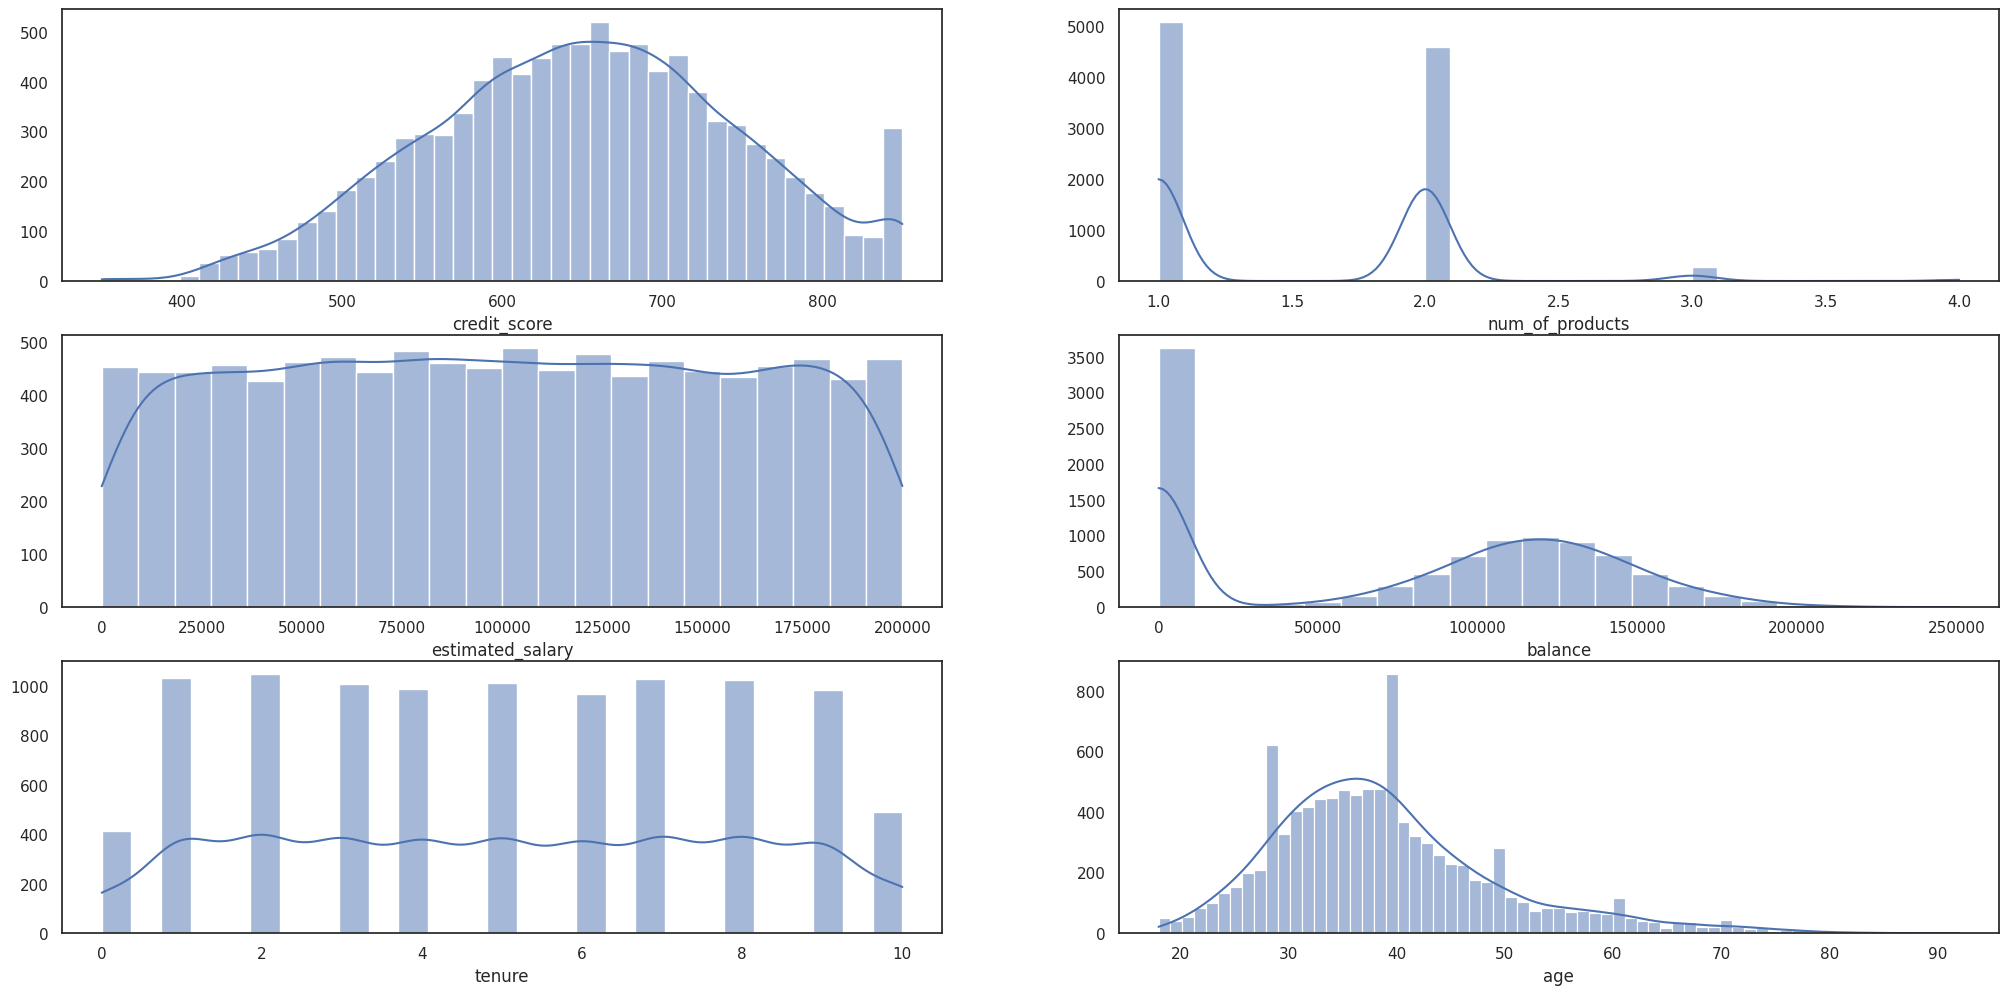

In [89]:
multiple_histplots(num_attributes, 3, 2);

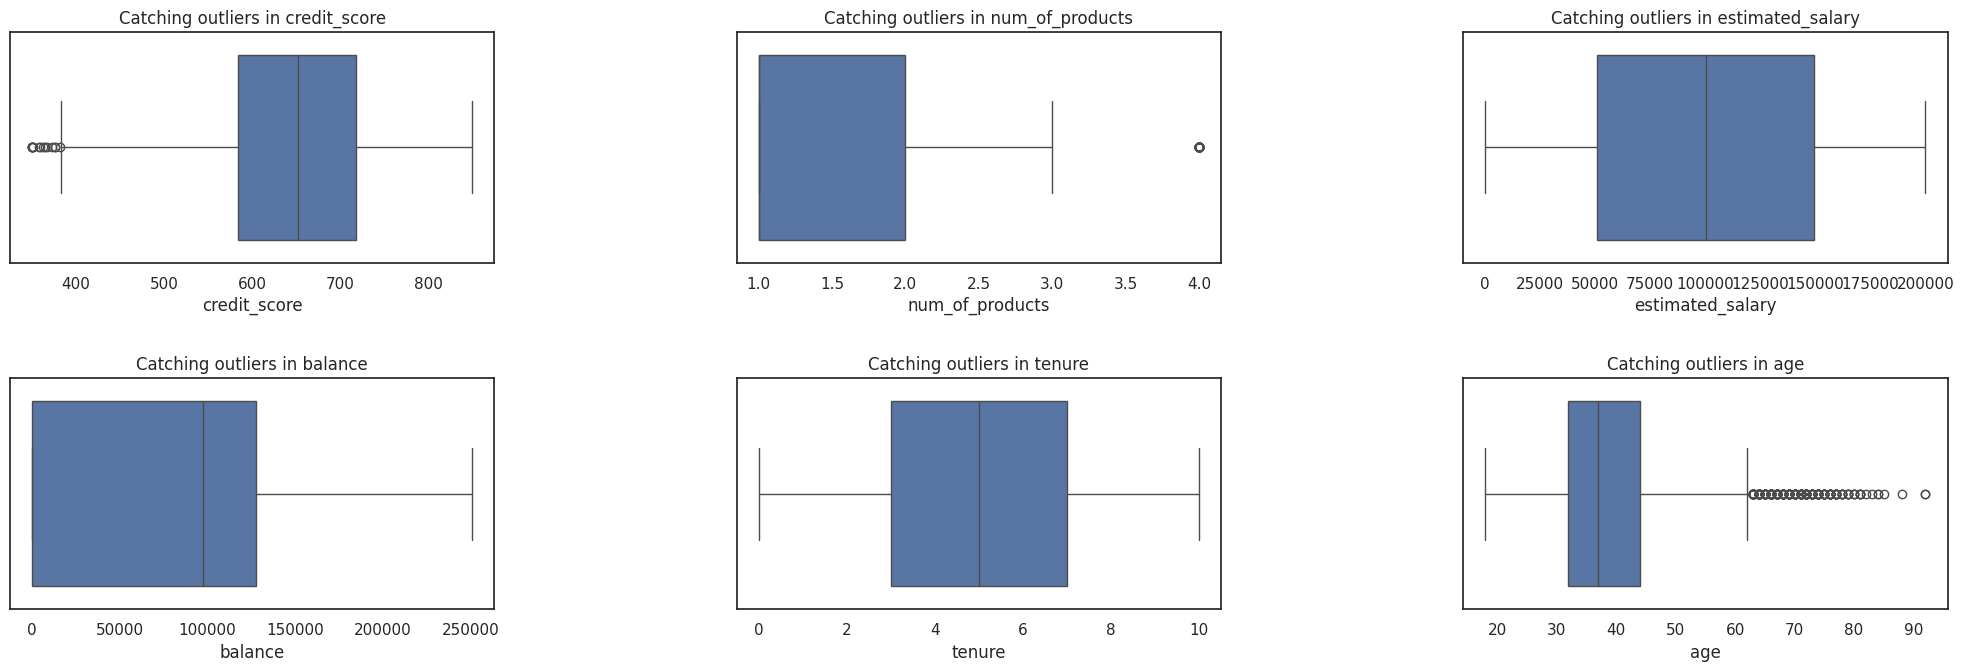

In [90]:
num_cols = num_attributes.columns.tolist()

i = 1
for col in df1[num_cols]:
    plt.subplot(3, 3, i)
    ax = sns.boxplot(data = df1, x = col, orient = 'h')
    ax.title.set_text(f'Catching outliers in {col}')
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    i += 1
    
# saving figure 
plt.savefig(homepath + 'reports/figures/numerical_attributes.png')


Negative outliers in `credit_score` and positive outliers in `num_of_products` and `age`

#### 1.6.2 Categorical Attributes

In [91]:

cat_attributes = df1_cat.select_dtypes(exclude = ['int64', 'float64'])
cat_attributes.drop(columns = 'surname', inplace = True)

In [92]:
categorical_metrics(cat_attributes, 'is_active_member')

,absolute,percent %
is_active_member,,
yes,5151,51.510
no,4849,48.490


In [93]:

categorical_metrics(cat_attributes, 'has_cr_card')

,absolute,percent %
has_cr_card,,
yes,7055,70.550
no,2945,29.450


In [94]:

categorical_metrics(cat_attributes, 'exited')

,absolute,percent %
exited,,
no,7963,79.630
yes,2037,20.370


In [95]:

categorical_metrics(cat_attributes, 'gender')

,absolute,percent %
gender,,
male,5457,54.570
female,4543,45.430


In [96]:

categorical_metrics(cat_attributes, 'geography')

,absolute,percent %
geography,,
france,5014,50.140
germany,2509,25.090
spain,2477,24.770


Important informations:
- There are outliers in **credit_score, num_of_products and age**
- The **churn ratio is 20.37%**;
- **70.6%** of the members **has credit card**;
- More than **50% of the clients** are **from France**

### 1.7 Data Filtering

In [97]:
# Removing unwanted columns
df1.drop(columns = ['row_number', 'surname'], inplace = True)

### 1.8 Save State

In [98]:
df1.to_pickle(homepath + 'data/processed/df1.pkl')

## 2. FEATURE ENGINEERING

### 2.1 Split Data

In [99]:
df2 = pd.read_pickle(homepath + 'data/processed/df1.pkl')

X = df2.drop(columns=['exited', 'customer_id'])
y = df2['exited']
ids = df2['customer_id']

# Train -> 70%
# Test -> 20%
X_train_temp, X_test, y_train_temp, y_test, id_train_temp, id_test = train_test_split(
    X, y, ids, test_size = 0.2, random_state = seed, stratify = y)

# Validation -> 10%
# if train = 80% x dataset, then val = 0.1/0.8 = 0.125
# 0.125 x 0.8 = 0.1
X_train, X_val, y_train, y_val, id_train, id_val = train_test_split(
    X_train_temp, y_train_temp, id_train_temp, test_size = 0.125, random_state = seed, stratify = y_train_temp)

### 2.2 Feature Creation

In [100]:
for dataframe in [X_train, X_test, X_val]:
    # balance_salary_ratio
    dataframe['balance_salary_ratio'] = dataframe['balance']/dataframe['estimated_salary']
    # credit_score_age_ratio
    dataframe['credit_score_age_ratio'] = dataframe['credit_score']/dataframe['age']
    # tenure_age_ratio
    dataframe['tenure_age_ratio'] = dataframe['tenure']/dataframe['age']
    # balance_indicator
    dataframe['balance_indicator'] = dataframe['balance'].apply(lambda x: 'high' if x >= 150000 else 'low')
    # life_stage
    dataframe['life_stage'] = dataframe['age'].apply(lambda x: 'adolescence' if x <= 20 else 'adulthood' if (
        x > 20) & (x <= 35) else 'middle_age' if (x > 35) & (x <= 50) else 'senior')
    # cs_category
    dataframe['cs_category'] = dataframe['credit_score'].apply(lambda x: 'low' if x < 500 else 'medium' if (
        x >= 500) & (x < 700) else 'high')
    # tenure_group
    dataframe['tenure_group'] = dataframe['tenure'].apply(lambda x: 'new' if x <= 3 else 'intermediate' if (
        x > 3) & (x <= 6) else 'long_standing')

# credit_score_per_gender
credit_per_gender_train, credit_per_gender_test, credit_per_gender_val = [dataframe.loc[:, ['gender', 'credit_score']].groupby('gender').mean().reset_index() for dataframe in [X_train, X_test, X_val]]

credit_per_gender_train.columns = ['gender', 'credit_score_per_gender']
credit_per_gender_test.columns = ['gender', 'credit_score_per_gender']
credit_per_gender_val.columns = ['gender', 'credit_score_per_gender']

X_train = pd.merge(X_train, credit_per_gender_train, on = 'gender', how = 'left')
X_test = pd.merge(X_test, credit_per_gender_test, on = 'gender', how = 'left')
X_val = pd.merge(X_val, credit_per_gender_val, on = 'gender', how = 'left')


# balance_age
balance_age_train, balance_age_test, balance_age_val = [dataframe.loc[:, ['age', 'balance']].groupby('age').mean().reset_index() for dataframe in [X_train, X_test, X_val]]

balance_age_train.columns = ['age', 'balance_per_age']
balance_age_test.columns = ['age', 'balance_per_age']
balance_age_val.columns = ['age', 'balance_per_age']

X_train = pd.merge(X_train, balance_age_train, on = 'age', how = 'left')
X_test = pd.merge(X_test, balance_age_test, on = 'age', how = 'left')
X_val = pd.merge(X_val, balance_age_val, on = 'age', how = 'left')


# estimated_salary_per_country
estimated_salary_country_train, estimated_salary_country_test, estimated_salary_country_val = [dataframe.loc[:, ['geography', 'estimated_salary']].groupby('geography').mean().reset_index() for dataframe in [X_train, X_test, X_val]]

estimated_salary_country_train.columns = ['geography', 'estimated_salary_per_country']
estimated_salary_country_test.columns = ['geography', 'estimated_salary_per_country']
estimated_salary_country_val.columns = ['geography', 'estimated_salary_per_country']

X_train = pd.merge(X_train, estimated_salary_country_train, on = 'geography', how = 'left')
X_test = pd.merge(X_test, estimated_salary_country_test, on = 'geography', how = 'left')
X_val = pd.merge(X_val, estimated_salary_country_val, on = 'geography', how = 'left')

# LTV
balance_tenure_train, balance_tenure_test, balance_tenure_val = [dataframe.loc[:, ['tenure', 'balance']].groupby('tenure').mean().reset_index() for dataframe in [X_train, X_test, X_val]]

balance_tenure_train.columns = ['tenure', 'ltv']
balance_tenure_test.columns = ['tenure', 'ltv']
balance_tenure_val.columns = ['tenure', 'ltv']

X_train = pd.merge(X_train, balance_tenure_train, on = 'tenure', how = 'left')
X_test = pd.merge(X_test, balance_tenure_test, on = 'tenure', how = 'left')
X_val = pd.merge(X_val, balance_tenure_val, on = 'tenure', how = 'left')

# tenure_per_country
tenure_country_train, tenure_country_test, tenure_country_val = [dataframe.loc[:, ['geography', 'tenure']].groupby('geography').mean().reset_index() for dataframe in [X_train, X_test, X_val]]

tenure_country_train.columns = ['geography', 'tenure_per_country']
tenure_country_test.columns = ['geography', 'tenure_per_country']
tenure_country_val.columns = ['geography', 'tenure_per_country']

X_train = pd.merge(X_train, tenure_country_train, on = 'geography', how = 'left')
X_test = pd.merge(X_test, tenure_country_test, on = 'geography', how = 'left')
X_val = pd.merge(X_val, tenure_country_val, on = 'geography', how = 'left')

### 2.3 Verify NA

In [101]:
verify_nan(X_train)

,Sum of NA,%NA
is_active_member,0,0.000
has_cr_card,0,0.000
credit_score,0,0.000
num_of_products,0,0.000
estimated_salary,0,0.000
balance,0,0.000
tenure,0,0.000
age,0,0.000
gender,0,0.000
geography,0,0.000


In [102]:
verify_nan(X_test)

,Sum of NA,%NA
is_active_member,0,0.000
has_cr_card,0,0.000
credit_score,0,0.000
num_of_products,0,0.000
estimated_salary,0,0.000
balance,0,0.000
tenure,0,0.000
age,0,0.000
gender,0,0.000
geography,0,0.000


In [103]:
verify_nan(X_val)

,Sum of NA,%NA
is_active_member,0,0.000
has_cr_card,0,0.000
credit_score,0,0.000
num_of_products,0,0.000
estimated_salary,0,0.000
balance,0,0.000
tenure,0,0.000
age,0,0.000
gender,0,0.000
geography,0,0.000


### 2.4 Save State

In [104]:
X_train.to_pickle(homepath + 'data/processed/X_train.pkl')
X_test.to_pickle(homepath + 'data/processed/X_test.pkl')
X_val.to_pickle(homepath + 'data/processed/X_val.pkl')

y_train.to_pickle(homepath + 'data/processed/y_train.pkl')
y_test.to_pickle(homepath + 'data/processed/y_test.pkl')
y_val.to_pickle(homepath + 'data/processed/y_val.pkl')

id_train.to_pickle(homepath + 'data/processed/id_train.pkl')
id_test.to_pickle(homepath + 'data/processed/id_test.pkl')
id_val.to_pickle(homepath + 'data/processed/id_val.pkl')

## 3. EXPLORATORY DATA ANALYSIS

### 3.1 Dataset Checkpoint

In [105]:
X_train = pd.read_pickle(homepath + 'data/processed/X_train.pkl')
y_train = pd.read_pickle(homepath + 'data/processed/y_train.pkl')

df3 = pd.merge(X_train, y_train, left_index = True, right_index = True)


### 3.2 Mind Map

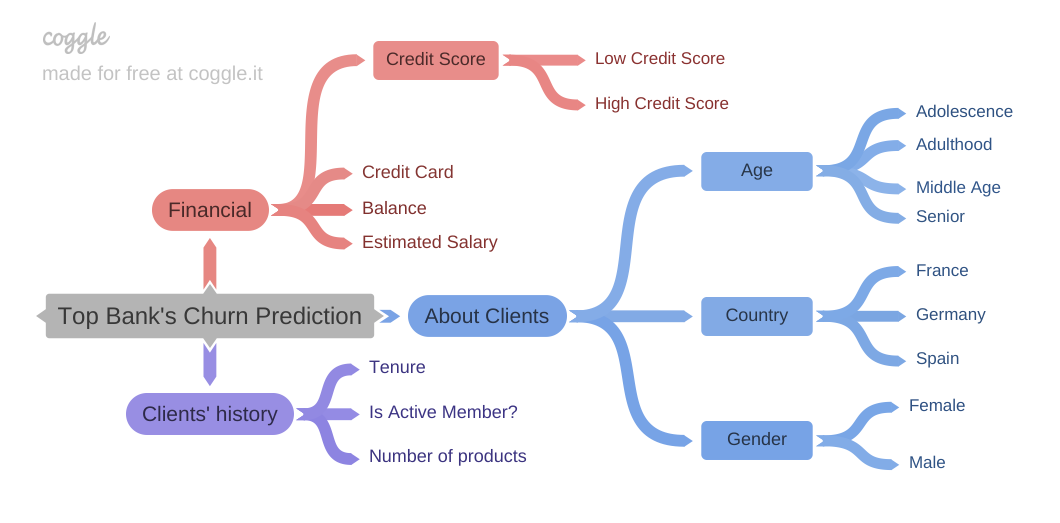

In [106]:
Image(homepath + 'reports/figures/mind_map.png')

### 3.3 Reports

#### 3.3.1 Overview

In [107]:
report_overview = sv.analyze(df3, target_feat ='exited')
report_overview.show_html(filepath = homepath + 'reports/report_overview.html', open_browser = False, layout = 'vertical', scale = None)


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)

Report /home/gutto/repos/github/client_churn_prediction/reports/report_overview.html was generated.


#### 3.3.2 Gender Comparation

In [108]:
gender_comparation = sv.compare_intra(df3, df3['gender'] == 'male', ['male', 'female'], target_feat = 'exited')
gender_comparation.show_html(filepath = homepath + 'reports/gender_comparation.html', open_browser = False, layout = 'vertical', scale = None)

Feature: exited (TARGET)                     |▍         | [  4%]   00:00 -> (00:00 left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)

Report /home/gutto/repos/github/client_churn_prediction/reports/gender_comparation.html was generated.


#### 3.3.3 Warnings

- balance has 36% zeros.
- tenure has 4% zeros.
- there are more women in churn (24%) than men (16%).
- not active members has more chance to be in churn (24%) than active members (16%).
- has_cr_card seems to have no relevance to the phenomenon.
- France has 50% of the clients of the bank but Germany has the highest churn ratio.

### 3.4 Univariate Analysis

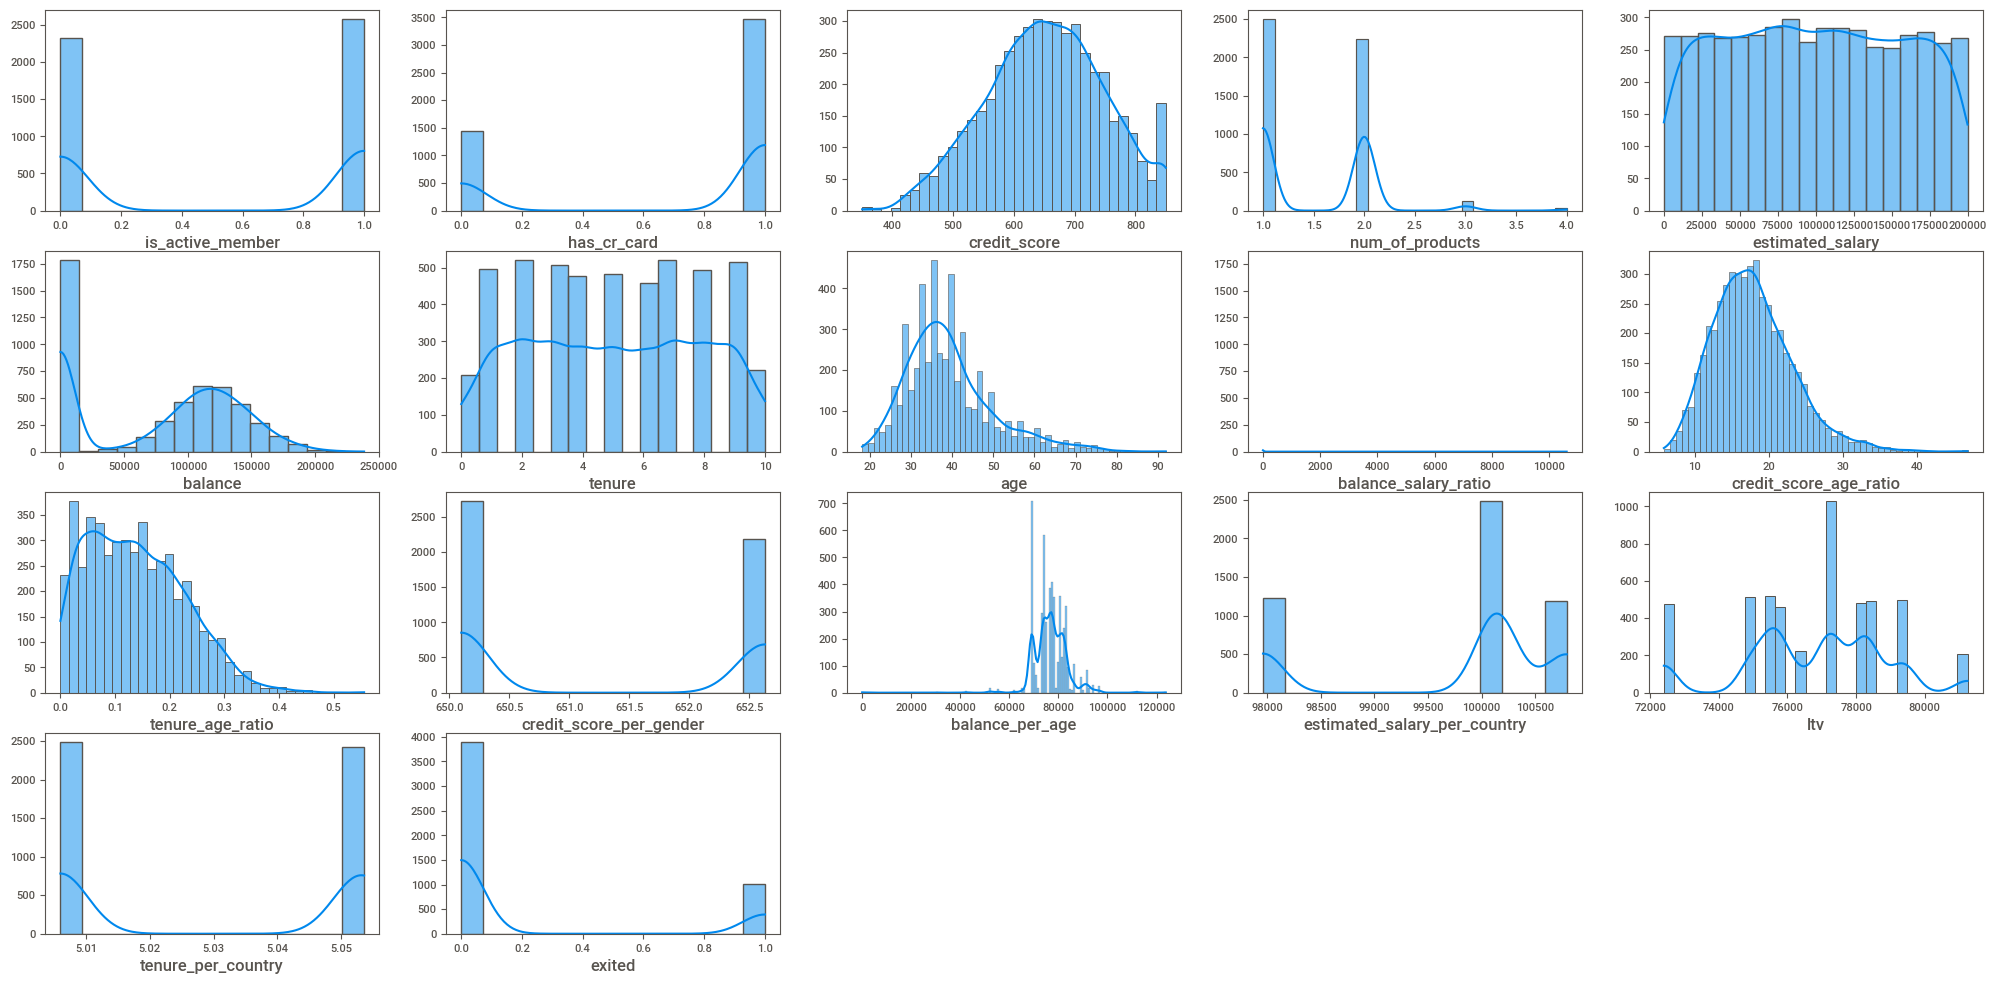

In [109]:
univariate_numerical = df3.select_dtypes(include=['int64', 'float64'])
multiple_histplots(univariate_numerical, 4, 5)

#saving figure
plt.savefig(homepath + 'reports/figures/univariate_analysis.png')


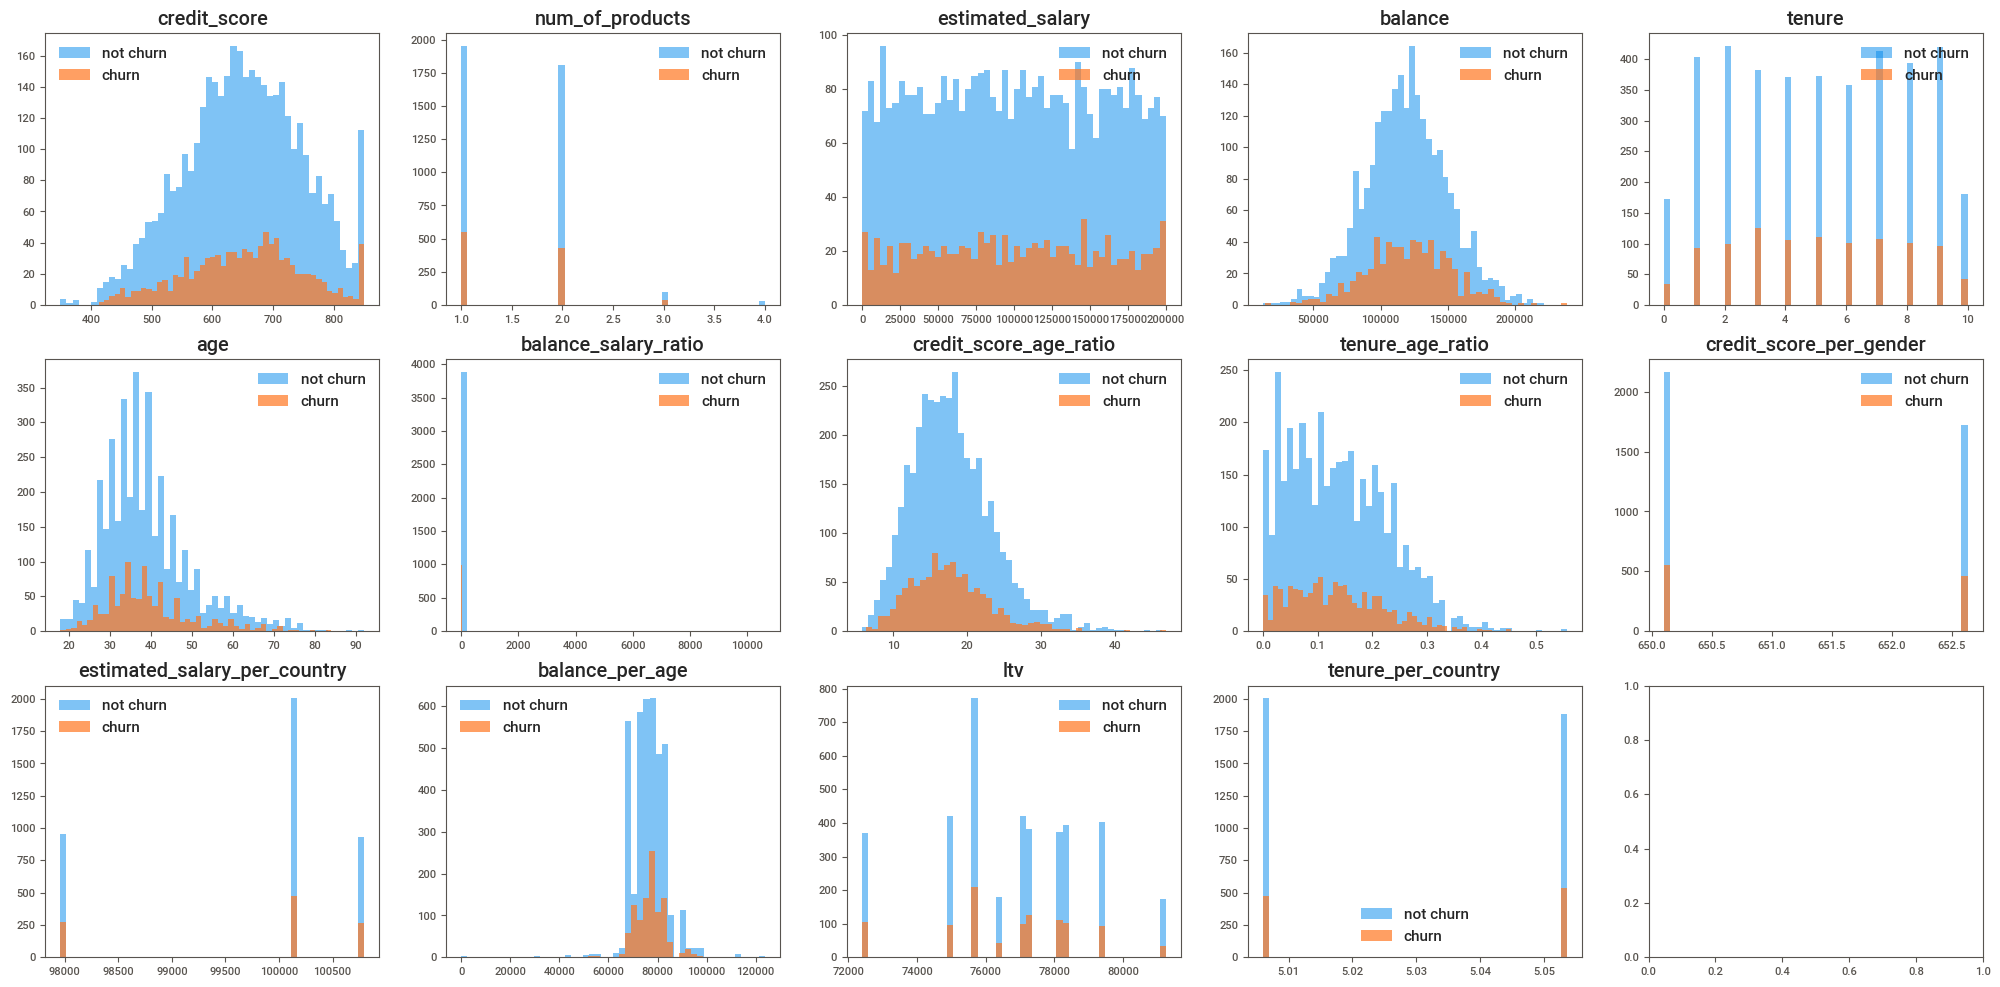

In [110]:
# Plot with target
univariate_numerical['exited'] = df3['exited']

# creating two datasets, one with churn and other with not churn hue
numerical_churn = univariate_numerical[univariate_numerical['exited'] == 1]
numerical_not_churn = univariate_numerical[univariate_numerical['exited'] == 0]

# creating aux datasets
aux_churn = numerical_churn[numerical_churn['balance'] != 0]
aux_not_churn = numerical_not_churn[numerical_not_churn['balance'] != 0]

# creating subplots
fig, ax = plt.subplots(3, 5)

# plot
plot_with_target(numerical_not_churn, numerical_churn,
                 'credit_score', 0, 0, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'num_of_products', 0, 1, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'estimated_salary', 0, 2, 'not churn', 'churn')
plot_with_target(aux_not_churn, aux_churn, 'balance',
                 0, 3, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'tenure', 0, 4, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'age', 1, 0, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'balance_salary_ratio', 1, 1, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'credit_score_age_ratio', 1, 2, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'tenure_age_ratio', 1, 3, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'credit_score_per_gender', 1, 4, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'estimated_salary_per_country', 2, 0, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'balance_per_age', 2, 1, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'ltv', 2, 2, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'tenure_per_country', 2, 3, 'not churn', 'churn')

#saving figure
plt.savefig(homepath + 'reports/figures/univariate_analysis_target.png')


### 3.5 Bivariate Analysis

#### 3.5.1 List of hypotheses

Number | Hypotheses
---    | ---
1      | Elderly clients has more tendency to be churn.
2      | Elderly people tend to not be in churn.
3      | Clients with more products has less tendency to be churn.
4      | Clients with a bad credit score tend to be in churn.
5      | Clients with higher estimated salaries tend to be in churn.

#### 3.5.2 Validation

#### **H1** Elderly clients has more tendency to be churn.
**True** Seniors has a higher churn tendency than others.

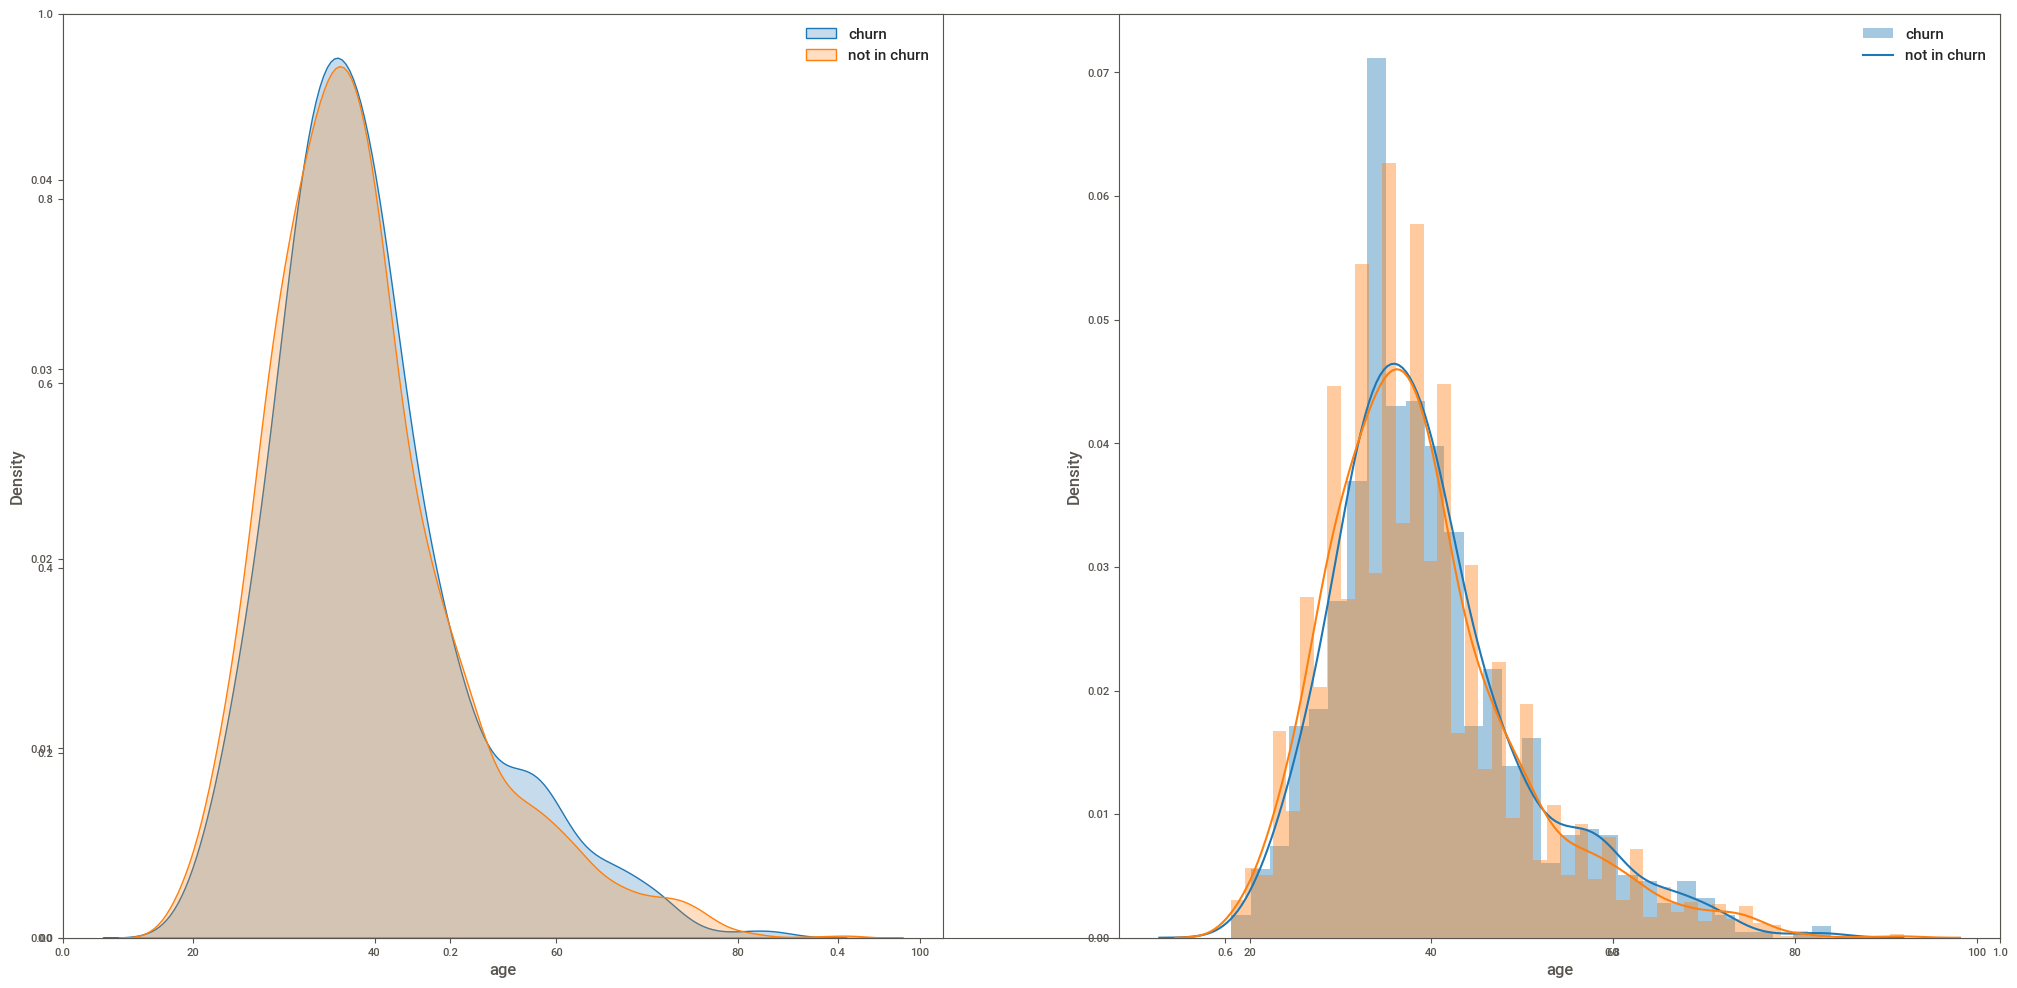

In [111]:
# creating subplots
fig, ax = plt.subplots()

plt.subplot(1, 2, 1)
ax = sns.kdeplot(df3[df3['exited'] == 1]['age'], label = 'churn', shade = True, color = '#1F77B4')
ax = sns.kdeplot(df3[df3['exited'] == 0]['age'], label = 'not in churn', shade = True, color = '#FF7F0E')
plt.legend(['churn', 'not in churn']) ;

plt.subplot(1, 2, 2)
ax2 = sns.distplot(df3[df3['exited'] == 1]['age'], label = 'churn', color = '#1F77B4')
ax2 = sns.distplot(df3[df3['exited'] == 0]['age'], label = 'not in churn', color = '#FF7F0E')
plt.legend(['churn', 'not in churn']);

#saving figure
plt.savefig(homepath + 'reports/figures/h1a.png')

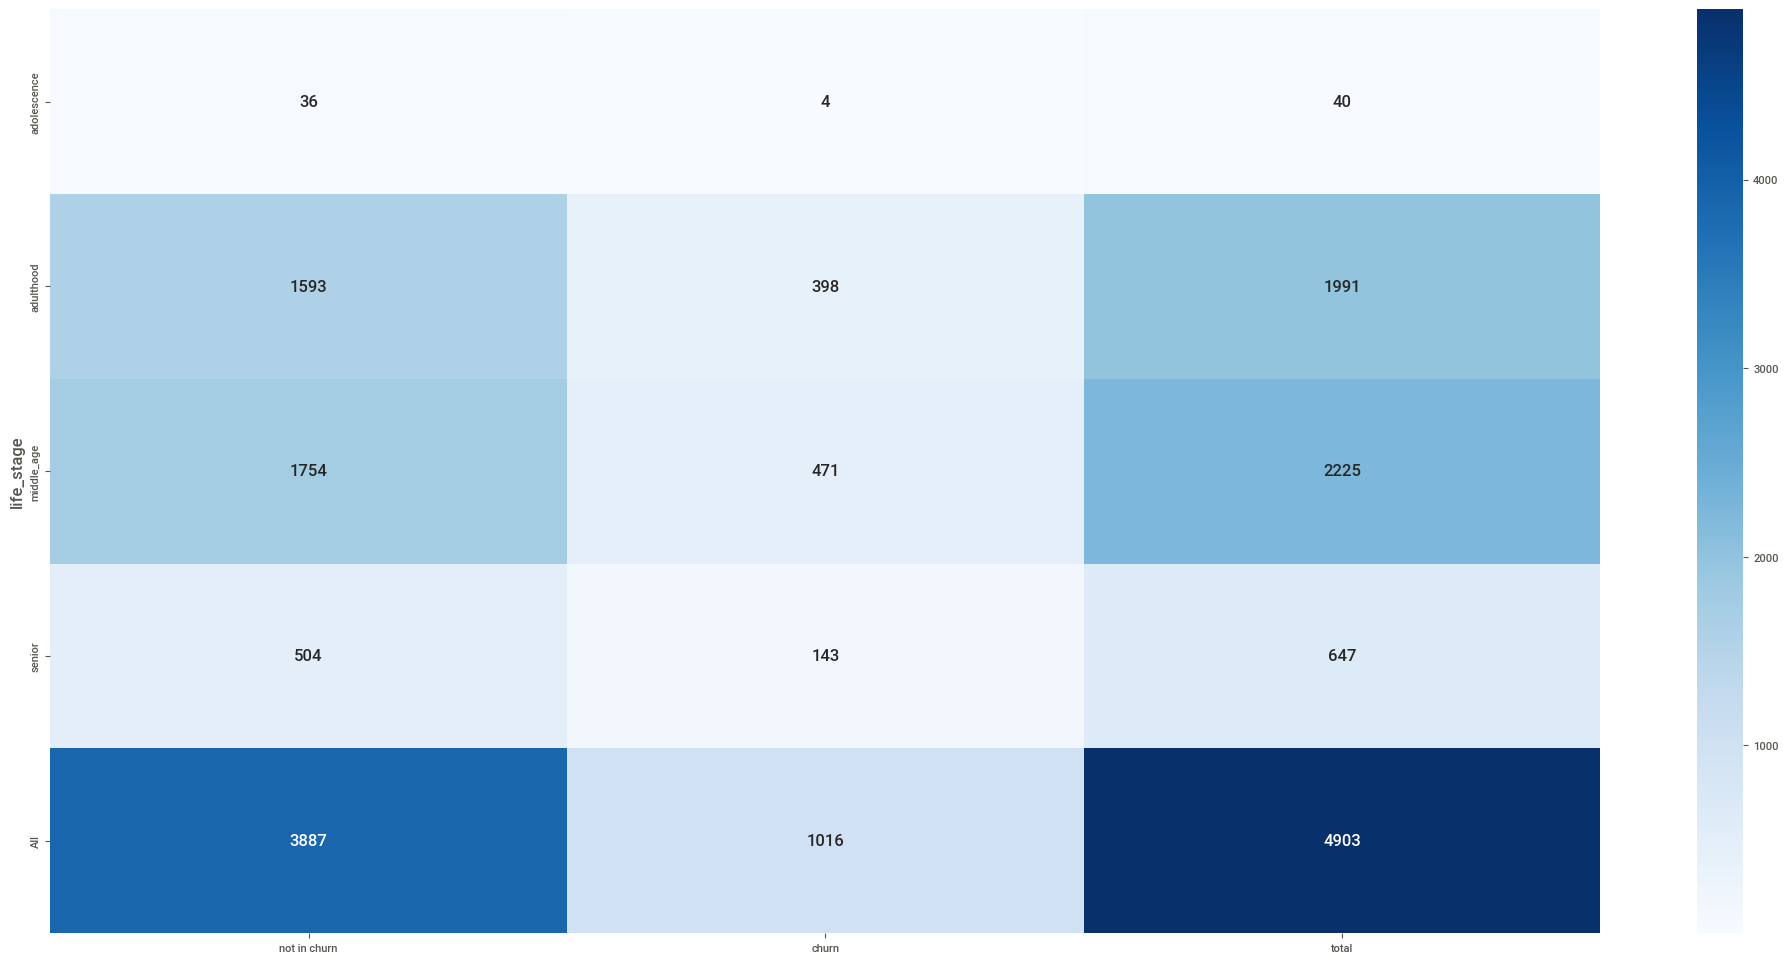

In [112]:
aux1 = df3[['has_cr_card', 'life_stage', 'exited']]

aux2 = aux1.pivot_table(values='has_cr_card',index='life_stage',columns='exited',aggfunc=['count'], margins = True)
aux2.columns = ['not in churn', 'churn', 'total']

ax = sns.heatmap(aux2, fmt = 'g', annot = True, cmap = 'Blues')

#saving figure
plt.savefig(homepath + 'reports/figures/h1b.png')

In [113]:
life_stage = ['adolescence' ,'adulthood' ,'middle_age', 'senior']
churn_percentage = [5/89*100, 332/4054*100, 1082/4541*100, (542/1240)*100]
h1 = pd.DataFrame({'life stage': life_stage, 'churn %': churn_percentage})
h1

,life stage,churn %
0,adolescence,5.618
1,adulthood,8.189
2,middle_age,23.827
3,senior,43.710


#### **H2** Elderly people tend to not be in churn.
**False** In proportion, clients with 60 years and above has more tendency to be in churn than adolescents and adults.

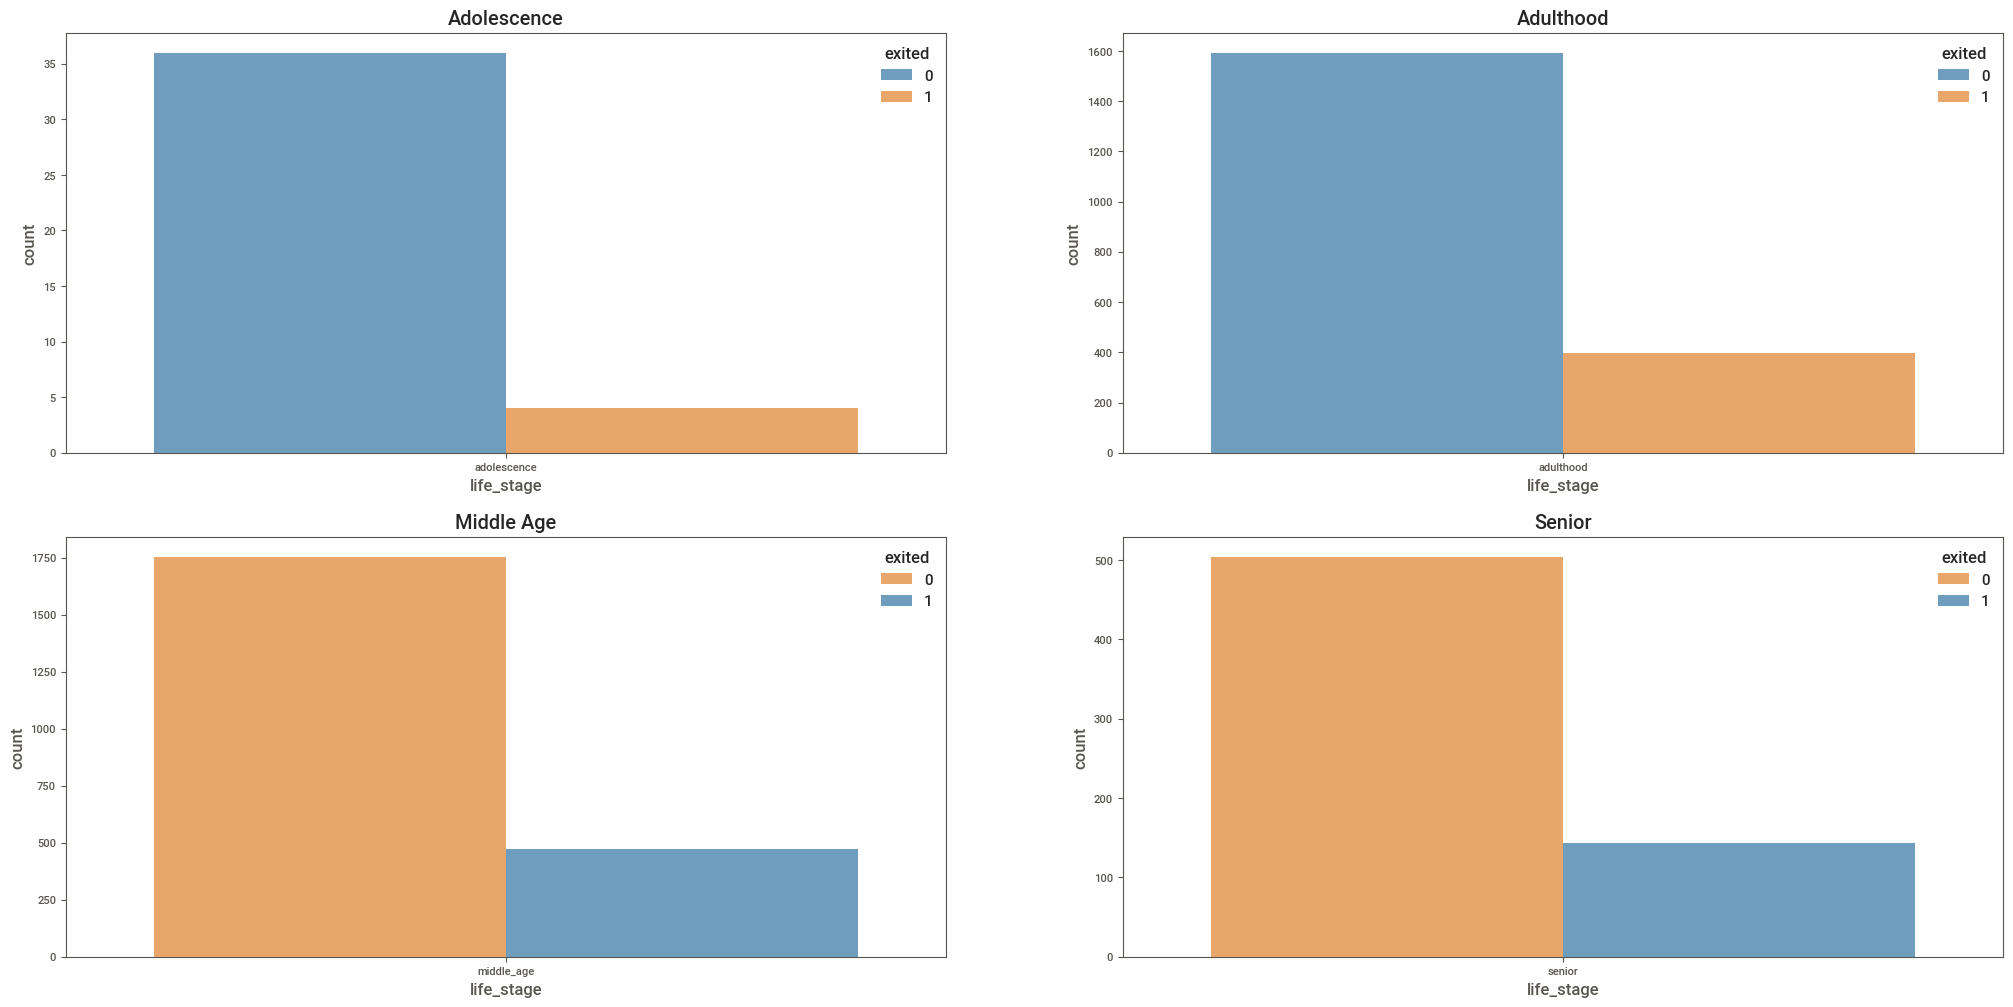

In [114]:
# creating aux dataframes
aux = df3[['life_stage', 'balance', 'exited']].copy()

# creating subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# plot
aux1 = aux.loc[(aux['life_stage'] == 'adolescence'), :] 
ax1 = sns.countplot(data = aux1, x = 'life_stage', hue = 'exited', alpha = 0.7, palette = ['#1F77B4', '#FF7F0E'], ax = ax1).set_title('Adolescence')

aux2 = aux.loc[(aux['life_stage'] == 'adulthood'), :] 
ax2 = sns.countplot(data = aux2, x = 'life_stage', hue = 'exited', alpha = 0.7, palette = ['#1F77B4', '#FF7F0E'], ax = ax2).set_title('Adulthood')

aux3 = aux.loc[(aux['life_stage'] == 'middle_age'), :] 
ax3 = sns.countplot(data = aux3, x = 'life_stage', hue = 'exited', alpha = 0.7, palette = ['#FF7F0E', '#1F77B4'], ax = ax3).set_title('Middle Age')

aux4 = aux.loc[(aux['life_stage'] == 'senior'), :] 
ax4 = sns.countplot(data = aux4, x = 'life_stage', hue = 'exited', alpha = 0.7, palette = ['#FF7F0E', '#1F77B4'], ax = ax4).set_title('Senior')

#saving figure
plt.savefig(homepath + 'reports/figures/h2.png')

In [115]:
categorical_metrics(aux, 'life_stage')

,absolute,percent %
life_stage,,
middle_age,2225,45.380
adulthood,1991,40.608
senior,647,13.196
adolescence,40,0.816


#### **H3** Clients with more products has less tendency to be churn.
**False** Clients with more products has more tendency to be churn.

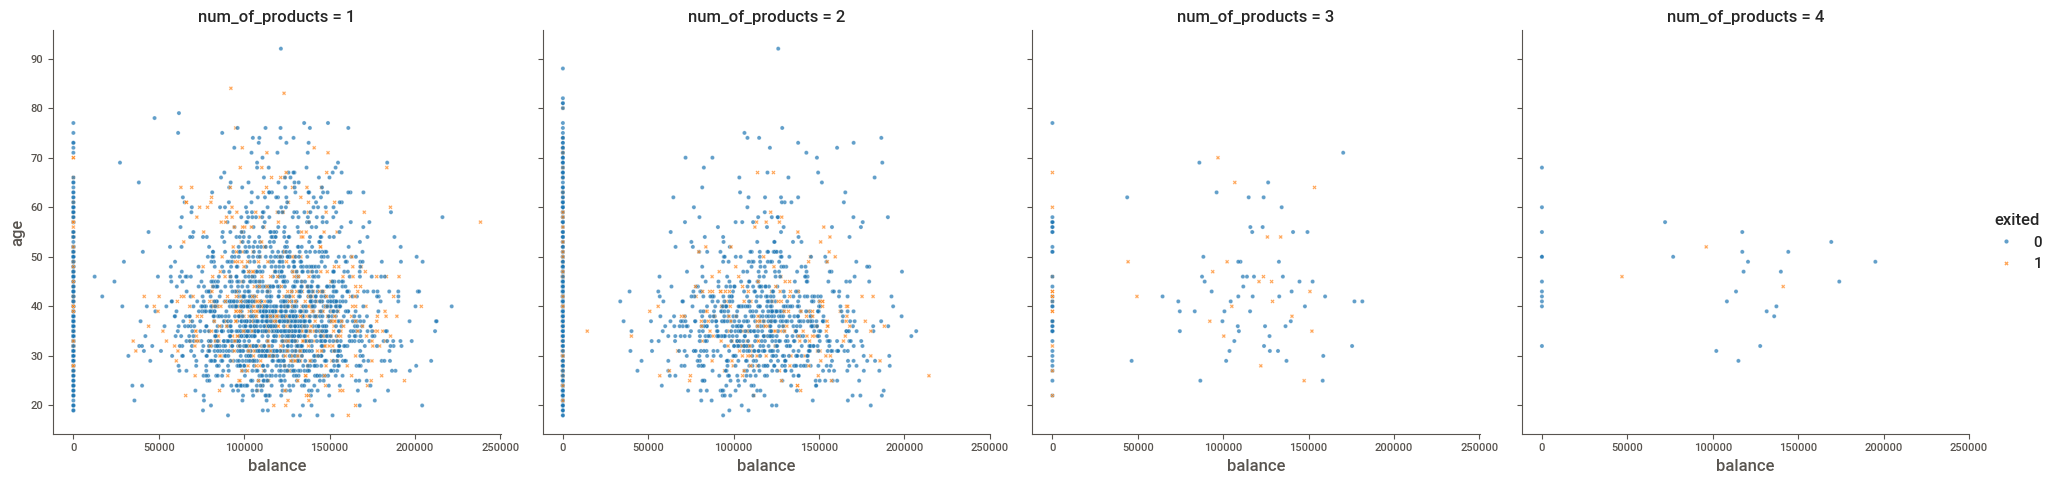

In [116]:
ax = sns.relplot(data = df3, x = 'balance', y = 'age', col = 'num_of_products', hue = 'exited', style = 'exited', alpha = 0.7, palette = 'tab10')

#saving figure
plt.savefig(homepath + 'reports/figures/h3.png')

#### **H4** Clients with a bad credit score tend to be in churn.
**False** Low and high credit score has a low relevance in churn.

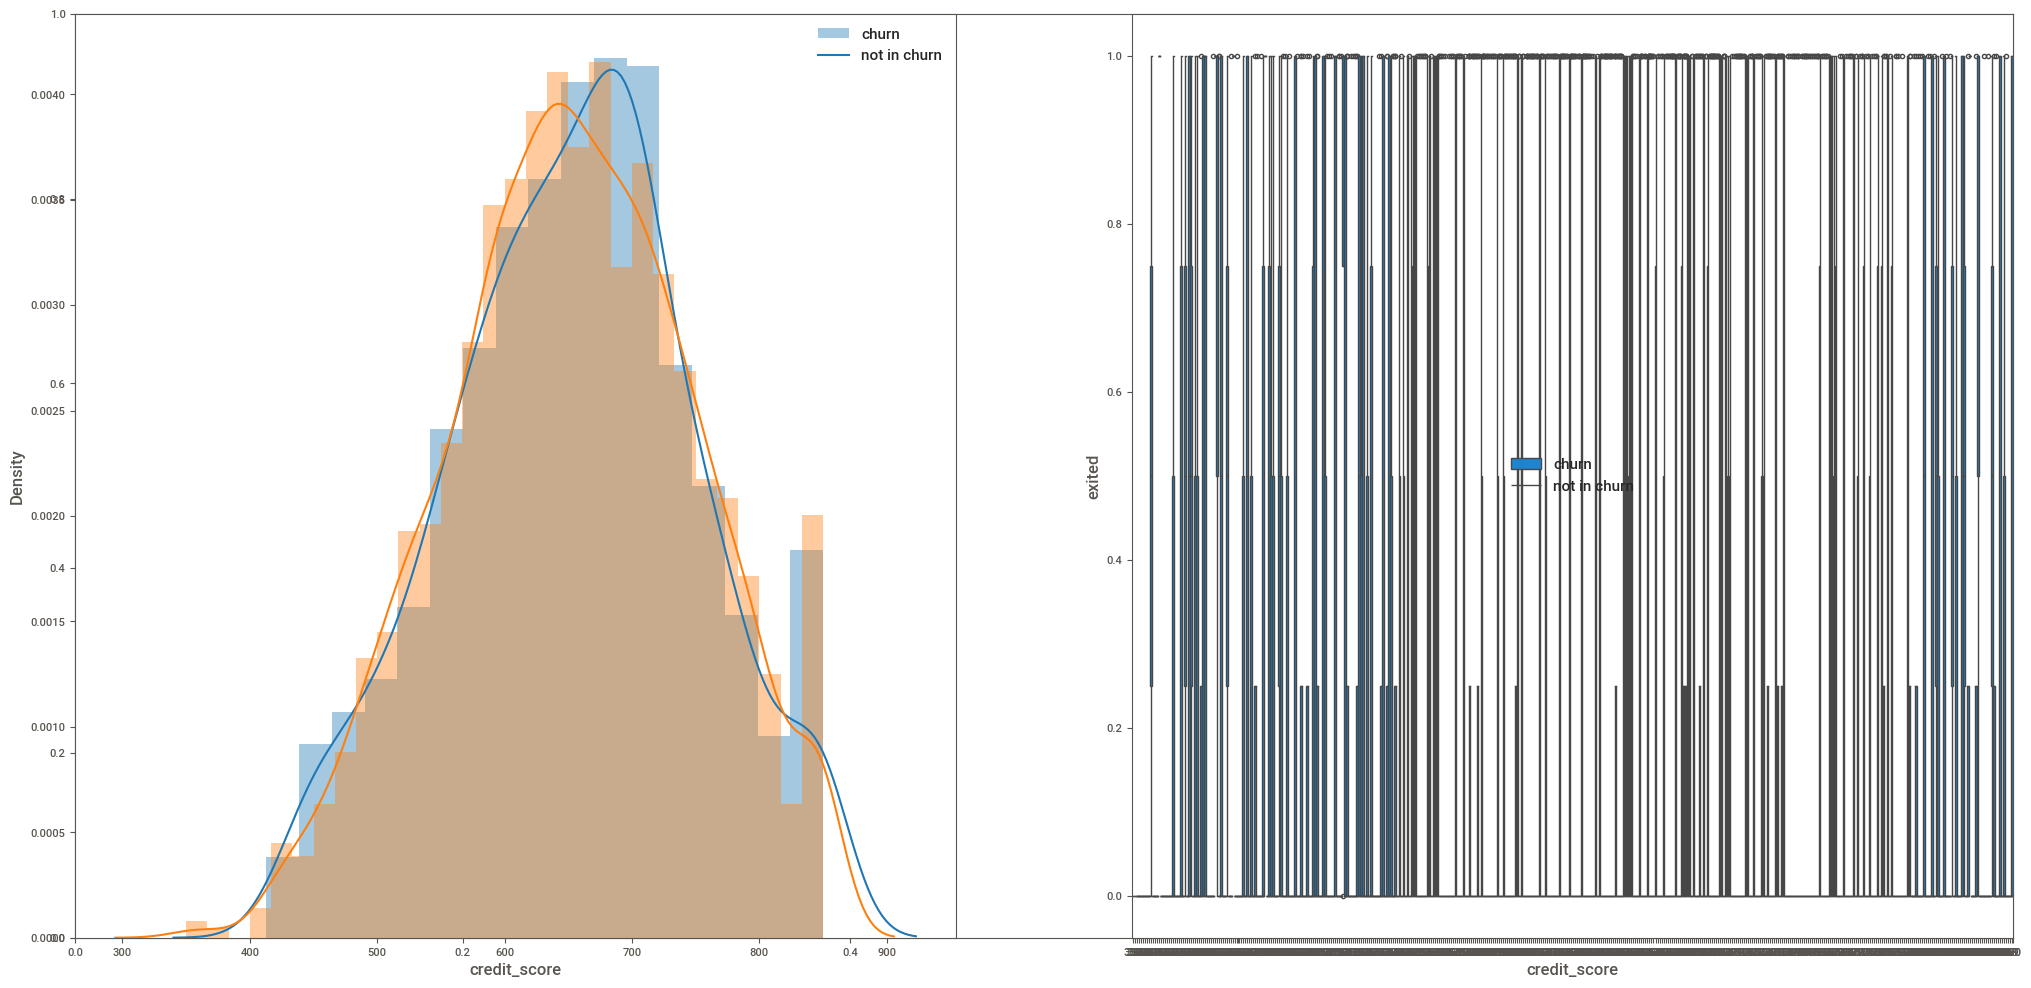

In [117]:
bivariate_churn_plots(df3, 'credit_score');

#saving figure
plt.savefig(homepath + 'reports/figures/h4a.png')

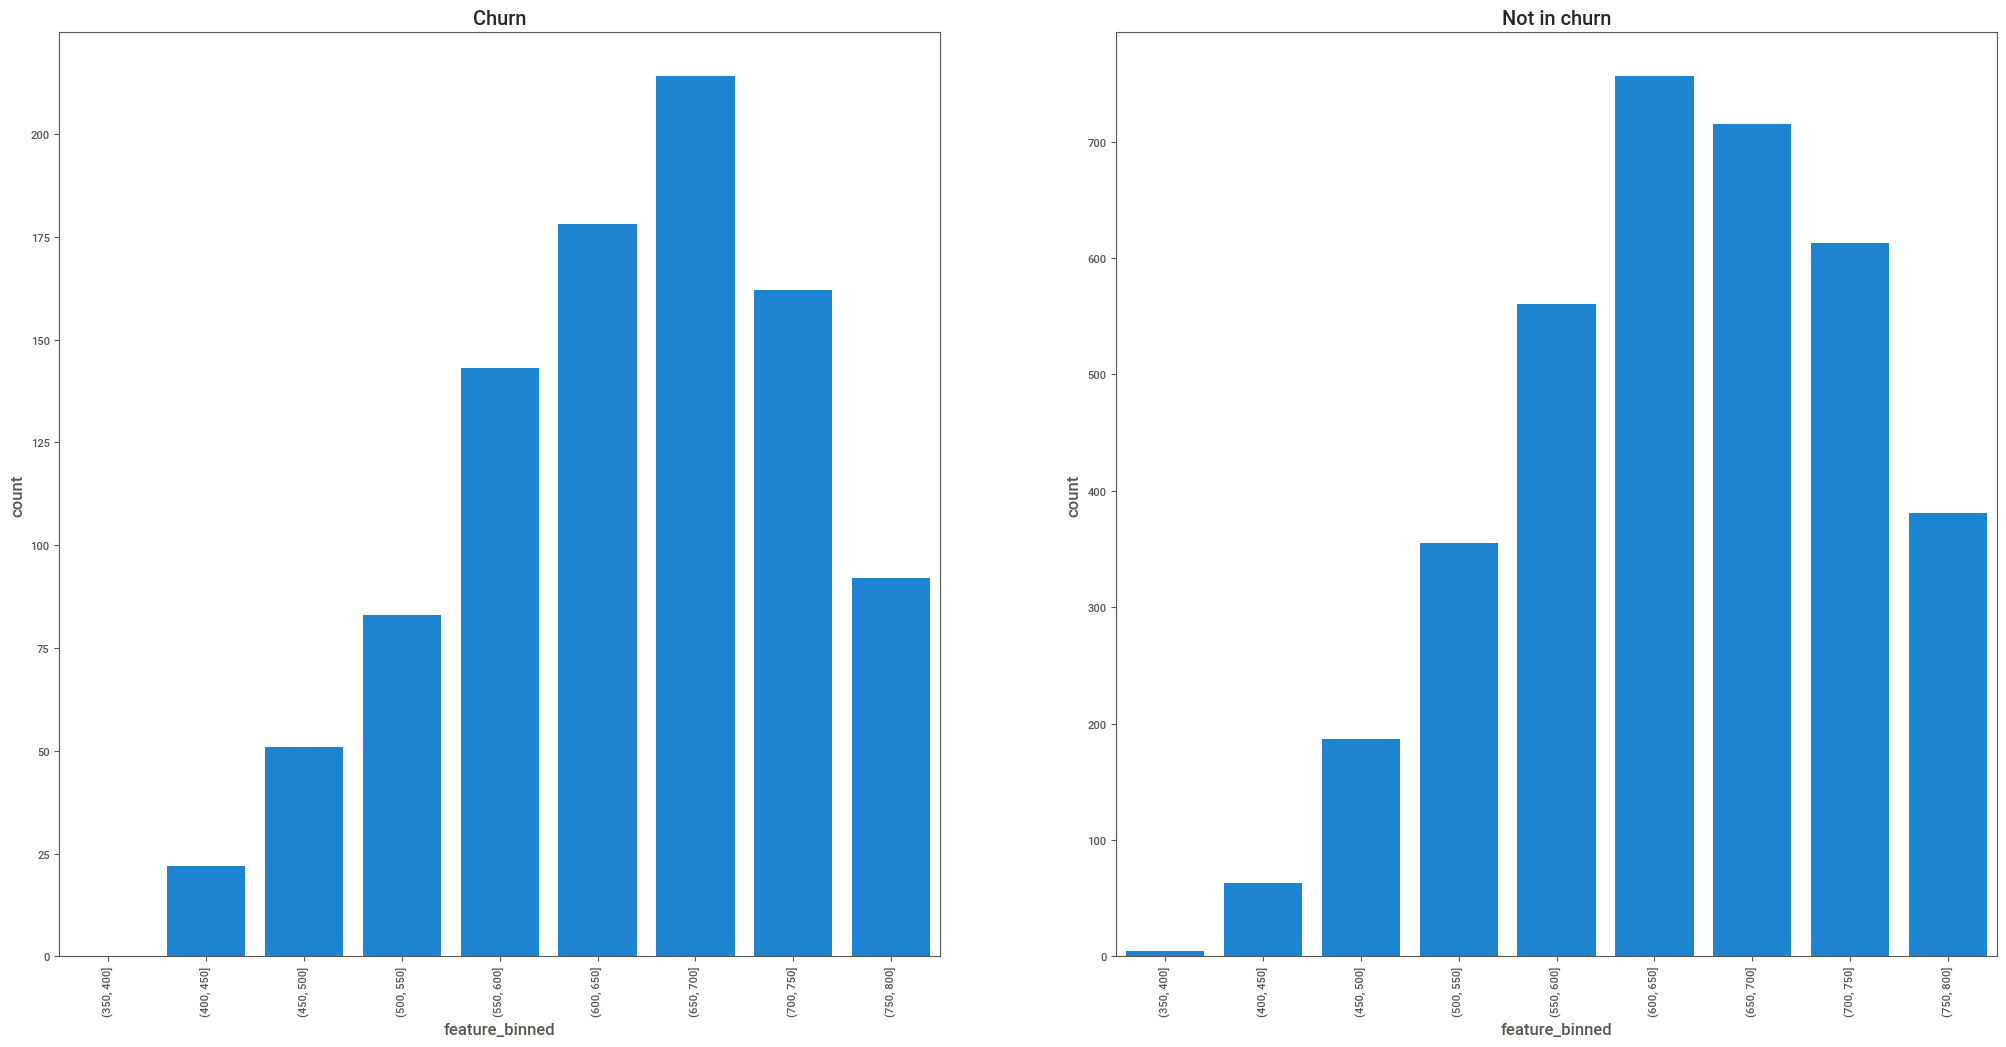

In [118]:
bivariate_bins_churn(350, 850, 50, df3, 'credit_score');

#saving figure
plt.savefig(homepath + 'reports/figures/h4b.png')

#### **H5** Clients with higher estimated salaries tend to be in churn.
**True** Clients with higher salaries has a slightly bigger chance to be a churn.

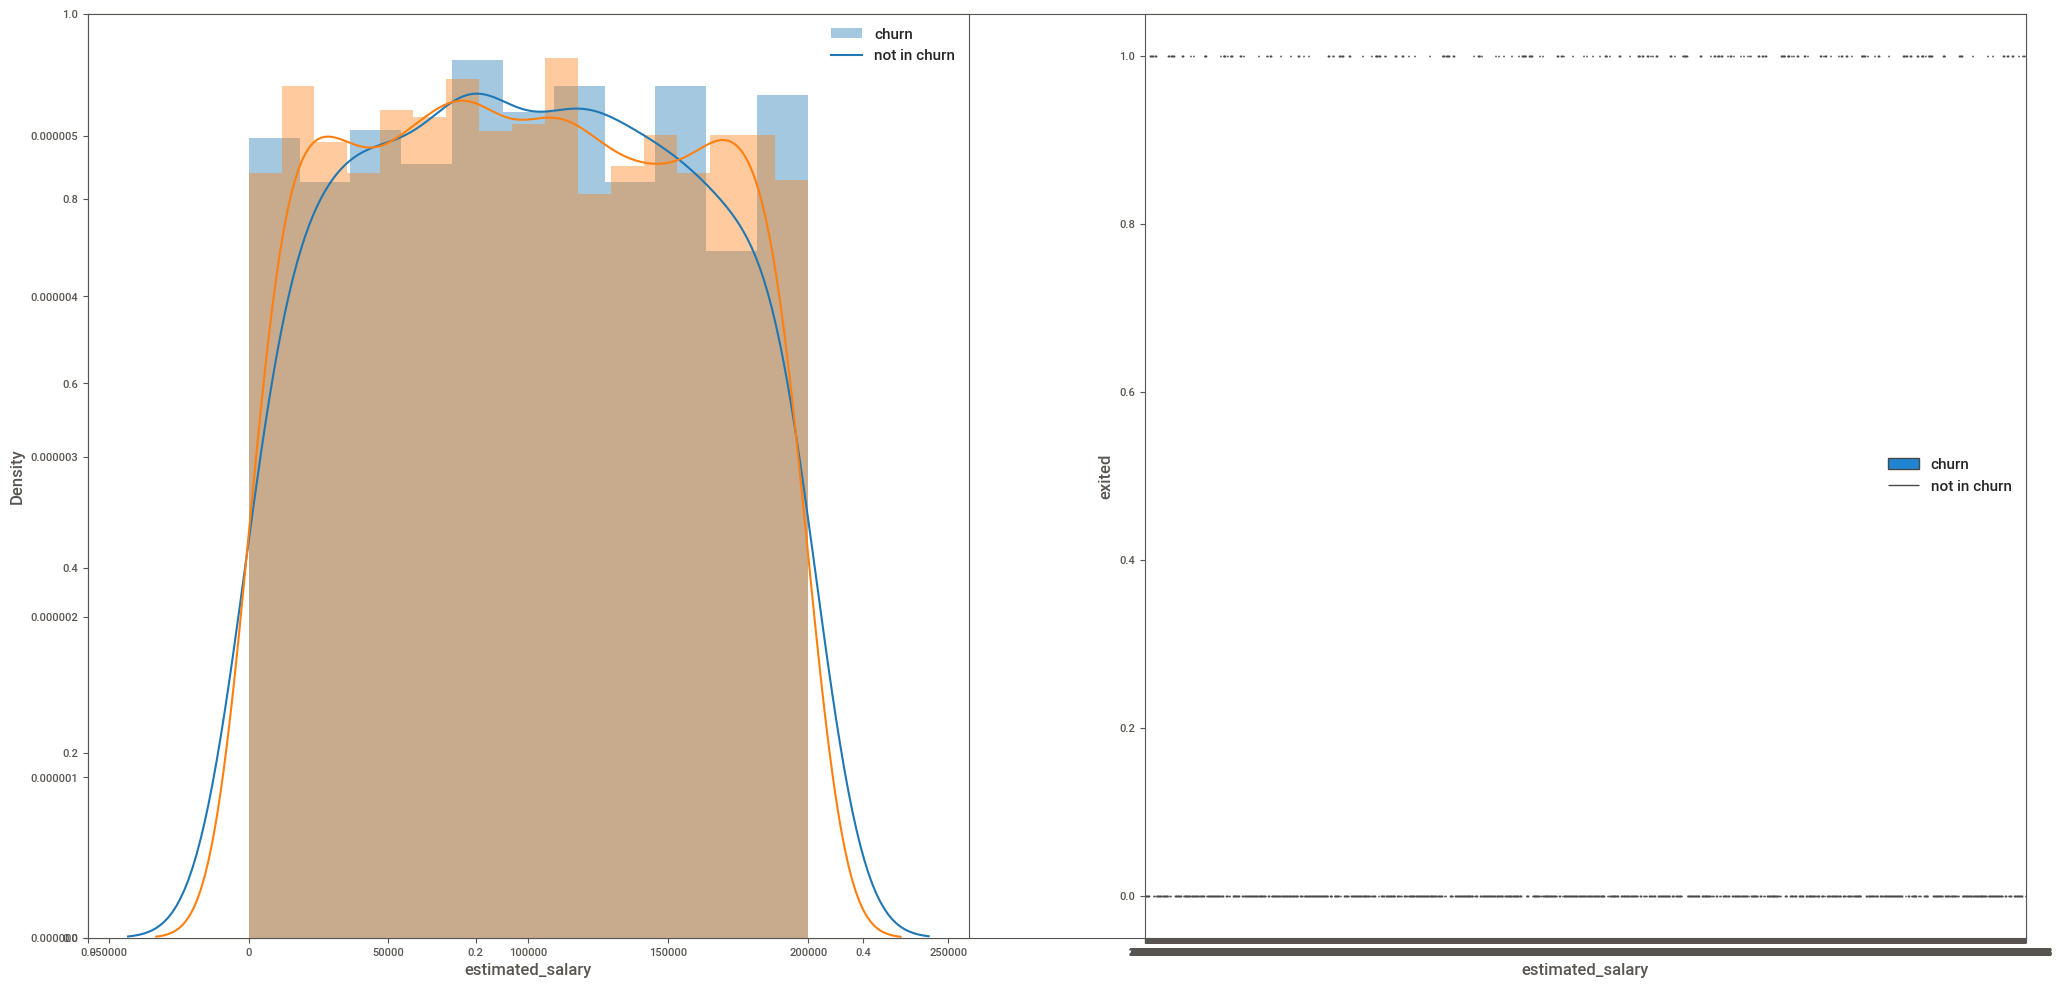

In [119]:
bivariate_churn_plots(df3, 'estimated_salary');

#saving figure
plt.savefig(homepath + 'reports/figures/h5a.png')

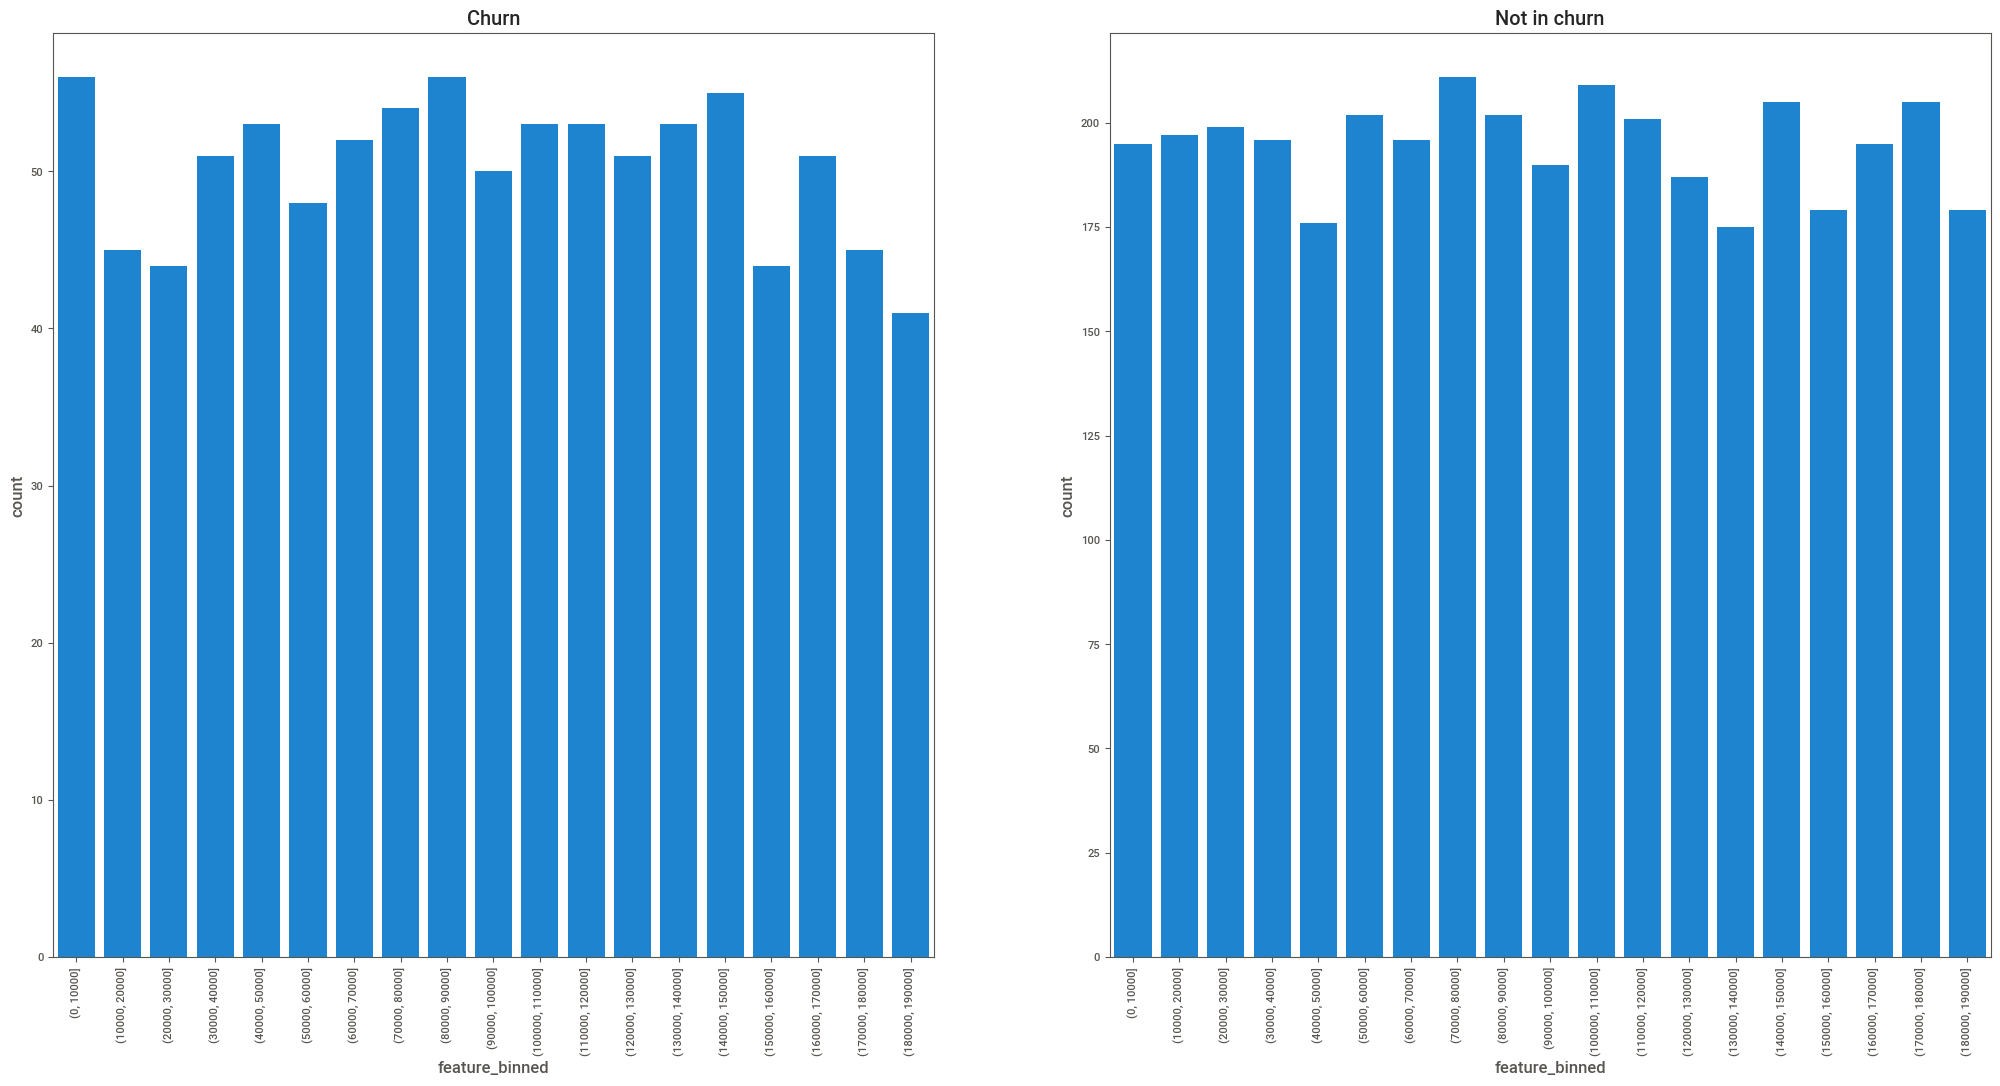

In [120]:
bivariate_bins_churn(0, 200000, 10000, df3, 'estimated_salary');

#saving figure
plt.savefig(homepath + 'reports/figures/h5b.png')

### 3.6 Multivariate Analysis

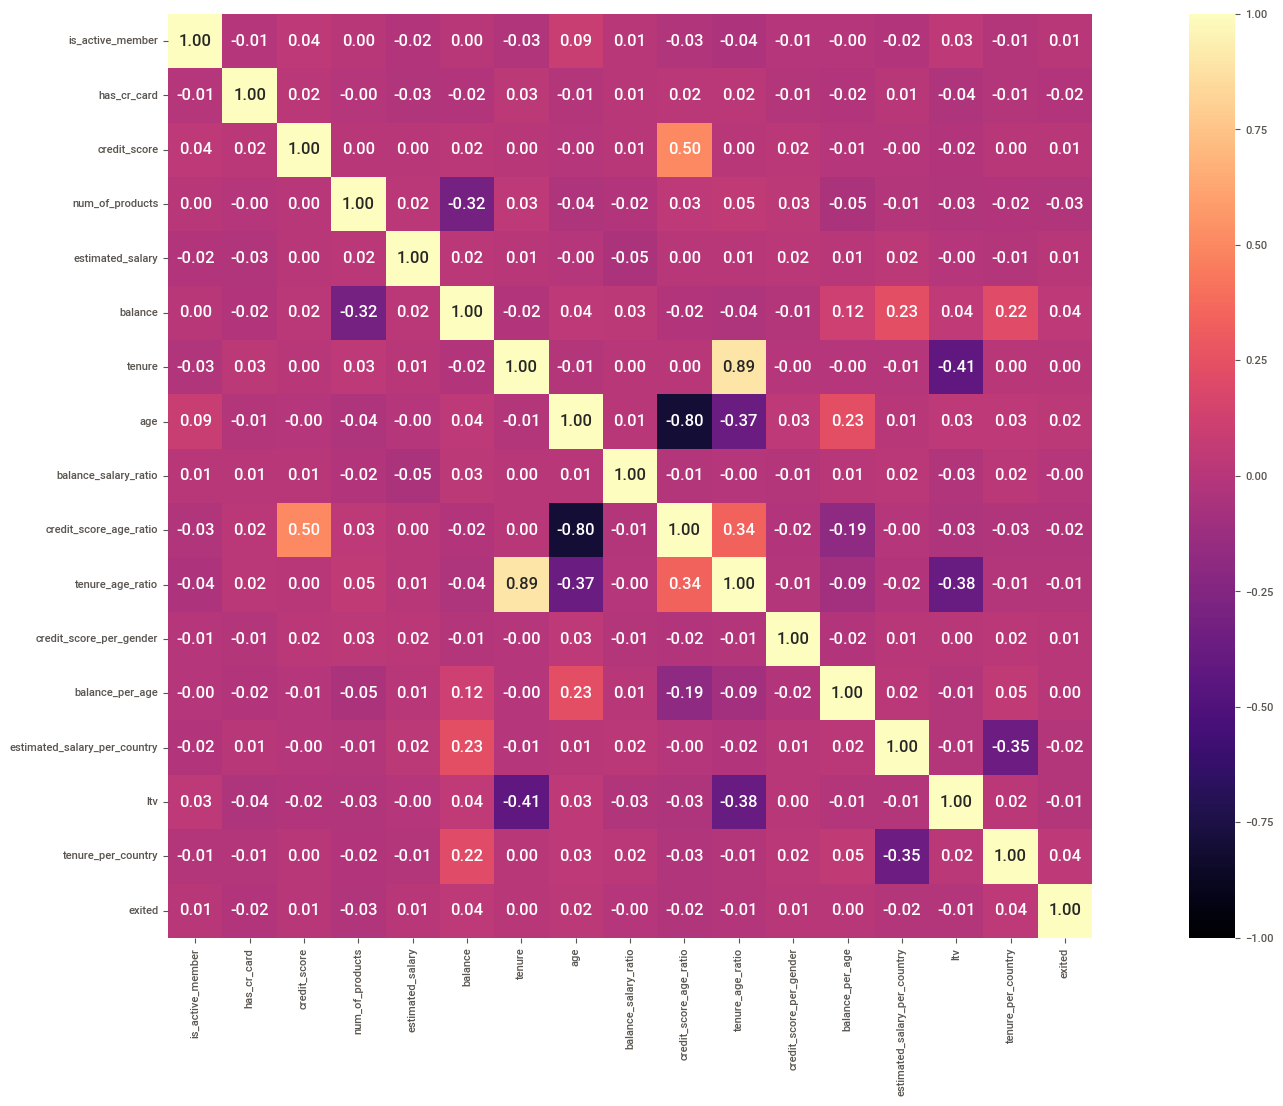

In [121]:
correlation_matrix(df3, 'pearson')

#saving figure
plt.savefig(homepath + 'reports/figures/correlation_matrix.png')

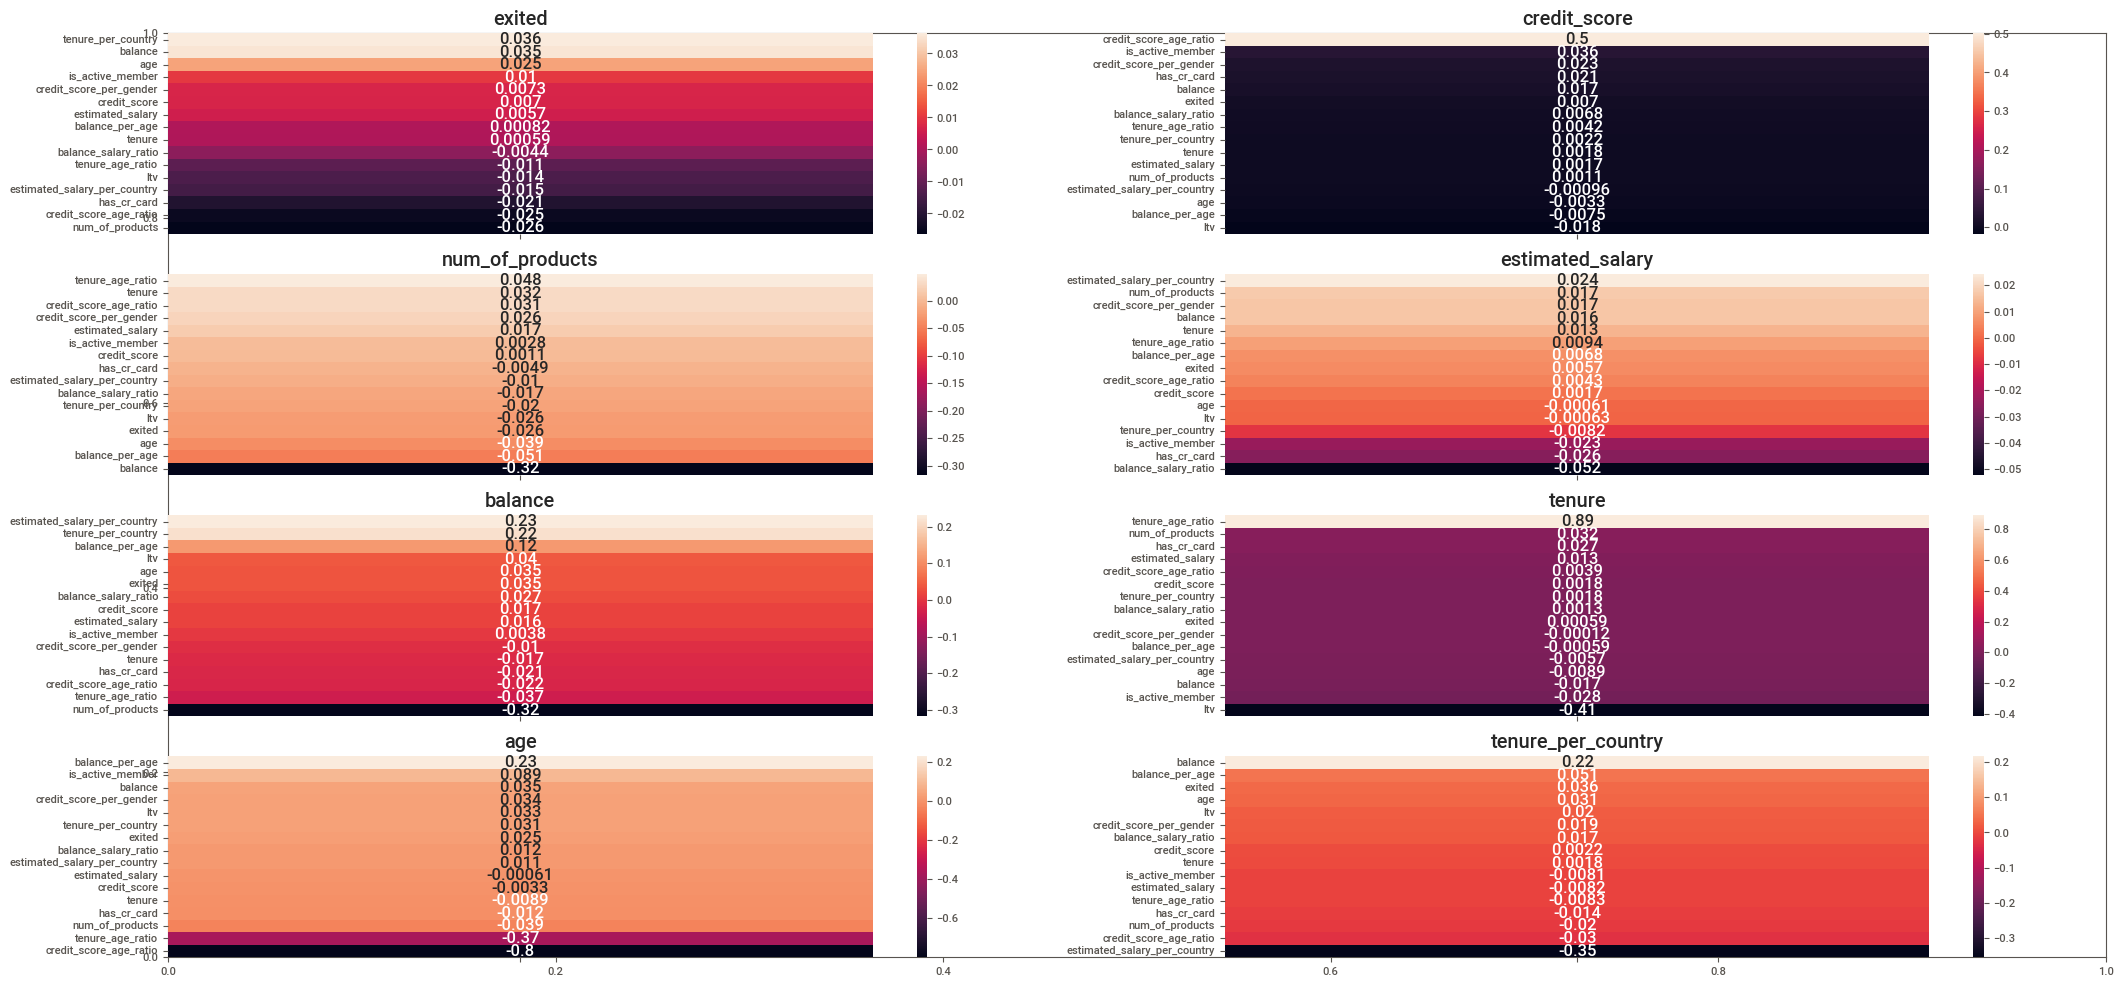

In [122]:
# creating subplots
fig, ax = plt.subplots()

plt.subplot(4, 2, 1)
correlation_ascending(df3, 'exited', 'pearson')

plt.subplot(4, 2, 2)
correlation_ascending(df3, 'credit_score', 'pearson')

plt.subplot(4, 2, 3)
correlation_ascending(df3, 'num_of_products', 'pearson')

plt.subplot(4, 2, 4)
correlation_ascending(df3, 'estimated_salary', 'pearson')

plt.subplot(4, 2, 5)
correlation_ascending(df3, 'balance', 'pearson')

plt.subplot(4, 2, 6)
correlation_ascending(df3, 'tenure', 'pearson')

plt.subplot(4, 2, 7)
correlation_ascending(df3, 'age', 'pearson')

plt.subplot(4, 2, 8)
correlation_ascending(df3, 'tenure_per_country', 'pearson');

#saving figure
plt.savefig(homepath + 'reports/figures/correlation_a.png')

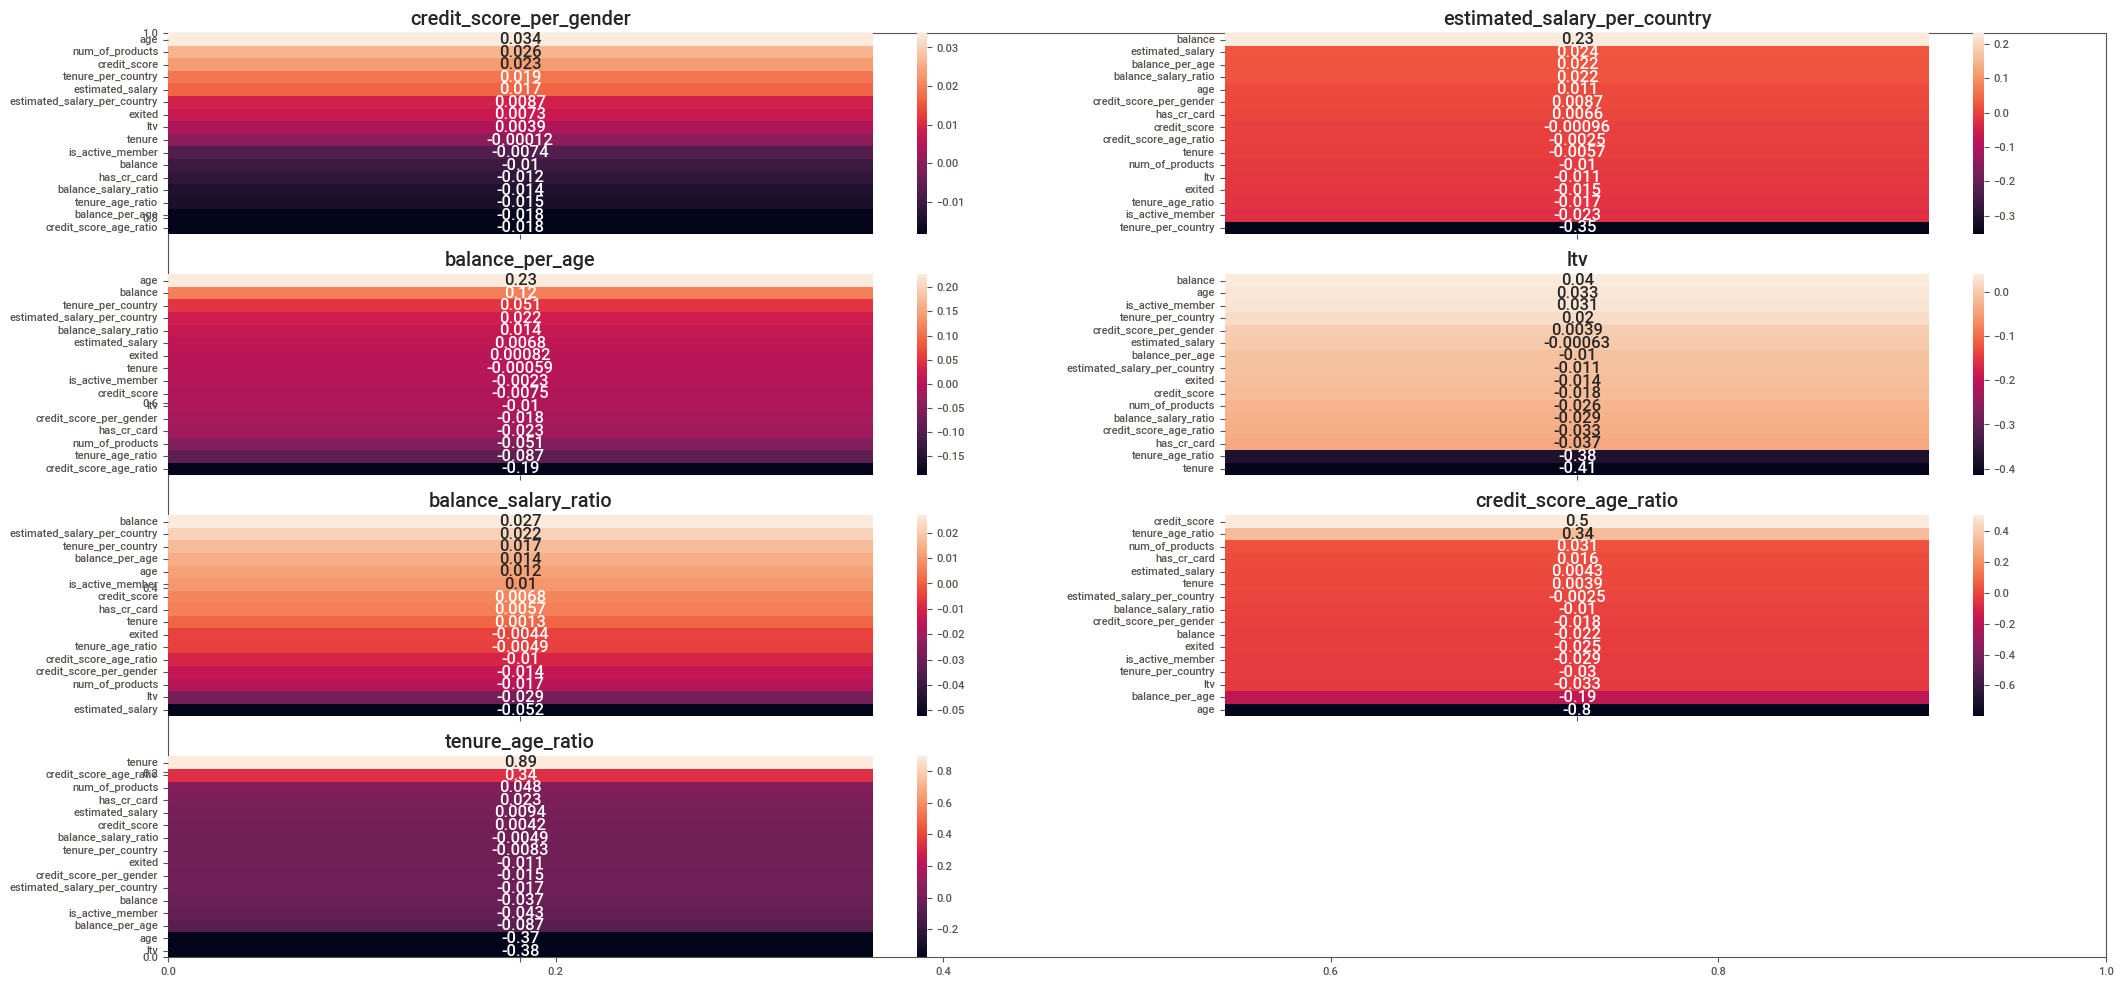

In [123]:
# creating subplots
fig, ax = plt.subplots()

plt.subplot(4, 2, 1)
correlation_ascending(df3, 'credit_score_per_gender', 'pearson')

plt.subplot(4, 2, 2)
correlation_ascending(df3, 'estimated_salary_per_country', 'pearson')

plt.subplot(4, 2, 3)
correlation_ascending(df3, 'balance_per_age', 'pearson')

plt.subplot(4, 2, 4)
correlation_ascending(df3, 'ltv', 'pearson');

plt.subplot(4, 2, 5)
correlation_ascending(df3, 'balance_salary_ratio', 'pearson');

plt.subplot(4, 2, 6)
correlation_ascending(df3, 'credit_score_age_ratio', 'pearson');

plt.subplot(4, 2, 7)
correlation_ascending(df3, 'tenure_age_ratio', 'pearson');

#saving figure
plt.savefig(homepath + 'reports/figures/correlation_b.png')

In [124]:
df3.head()


,is_active_member,has_cr_card,credit_score,num_of_products,estimated_salary,balance,tenure,age,gender,geography,balance_salary_ratio,credit_score_age_ratio,tenure_age_ratio,balance_indicator,life_stage,cs_category,tenure_group,credit_score_per_gender,balance_per_age,estimated_salary_per_country,ltv,tenure_per_country,exited
0,1,0,549,2,116548.020,137592.310,1,55,female,germany,1.181,9.982,0.018,low,senior,medium,new,652.632,80894.001,100794.300,79372.569,5.054,1
1,1,0,501,2,133403.070,88977.390,9,38,male,germany,0.667,13.184,0.237,low,middle_age,medium,long_standing,650.100,74039.613,100794.300,74954.897,5.054,0
2,0,1,710,2,155593.740,133537.100,10,30,female,germany,0.858,23.667,0.333,low,adulthood,high,long_standing,652.632,74335.998,100794.300,76308.318,5.054,1
3,1,0,648,1,129980.930,125681.510,7,31,male,germany,0.967,20.903,0.226,low,adulthood,medium,long_standing,650.100,77056.261,100794.300,75611.951,5.054,0
4,1,1,598,1,84136.120,171283.910,10,27,female,germany,2.036,22.148,0.370,high,adulthood,medium,long_standing,652.632,73370.242,100794.300,76308.318,5.054,0


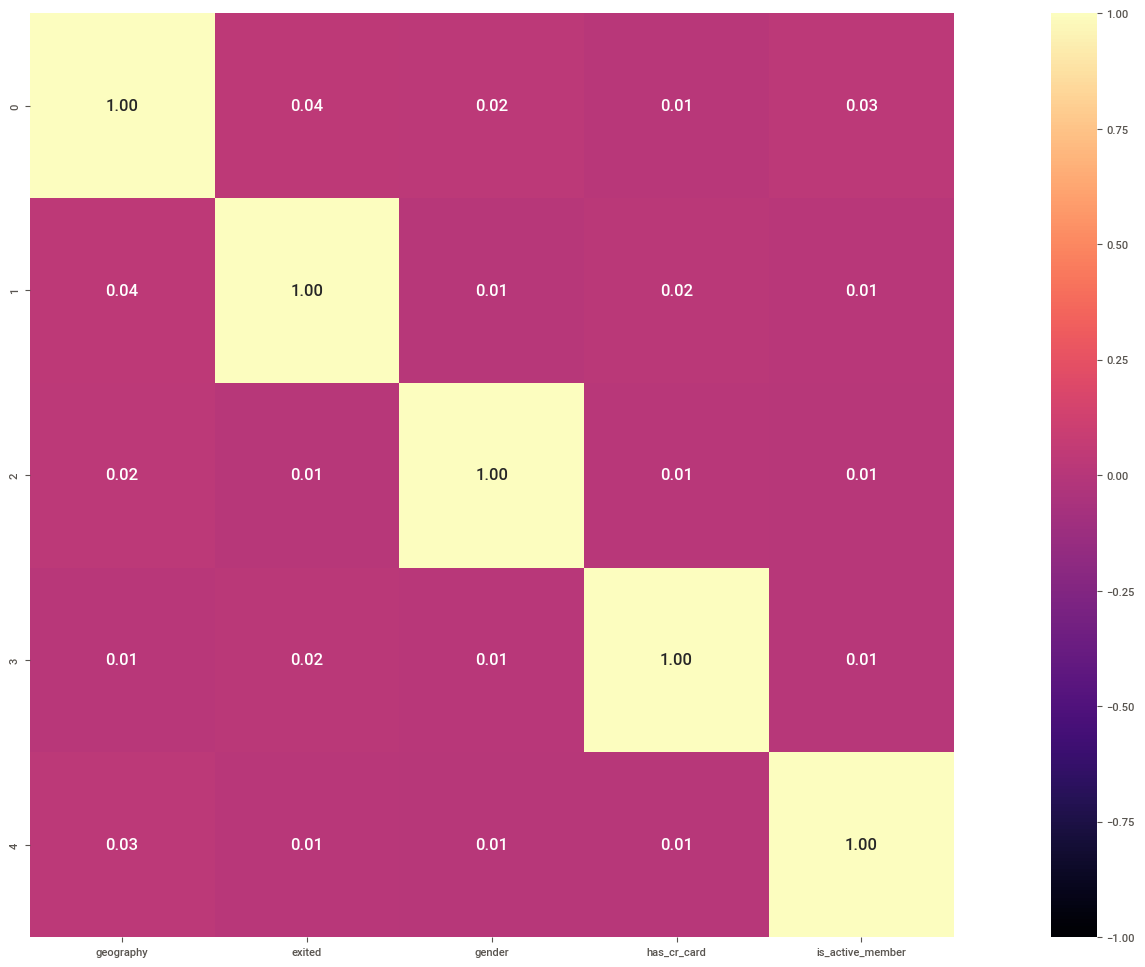

In [125]:

cat_features = df3[['geography', 'exited', 'gender', 'has_cr_card', 'is_active_member']]
cat_corr = pd.DataFrame(cramers_v(cat_features))
sns.heatmap(cat_corr, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True);

## 4. Machine Learning Modelling

### 4.1 Dataset Checkpoint

In [126]:
X_train = pd.read_pickle(homepath + 'data/processed/X_train.pkl')
X_test = pd.read_pickle(homepath + 'data/processed/X_test.pkl')
X_val = pd.read_pickle(homepath + 'data/processed/X_val.pkl')

y_train = pd.read_pickle(homepath + 'data/processed/y_train.pkl')
y_test = pd.read_pickle(homepath + 'data/processed/y_test.pkl')
y_val = pd.read_pickle(homepath + 'data/processed/y_val.pkl')

### 4.2 Encoding and Rescaling
---
1. Without Outlier and With Normal Distribution: Standard Scaler (Mean and std deviation)
2. With Outliers and Normal Distribution: Robust Scaler (Quartile)
3. Without Normal Distribution: MinMax Scaler

In [127]:
for dataframe in [X_train, X_test, X_val]:
    dataframe['age'] = np.log(dataframe['age'])
    dataframe['credit_score_age_ratio'] = np.log(dataframe['credit_score_age_ratio'])

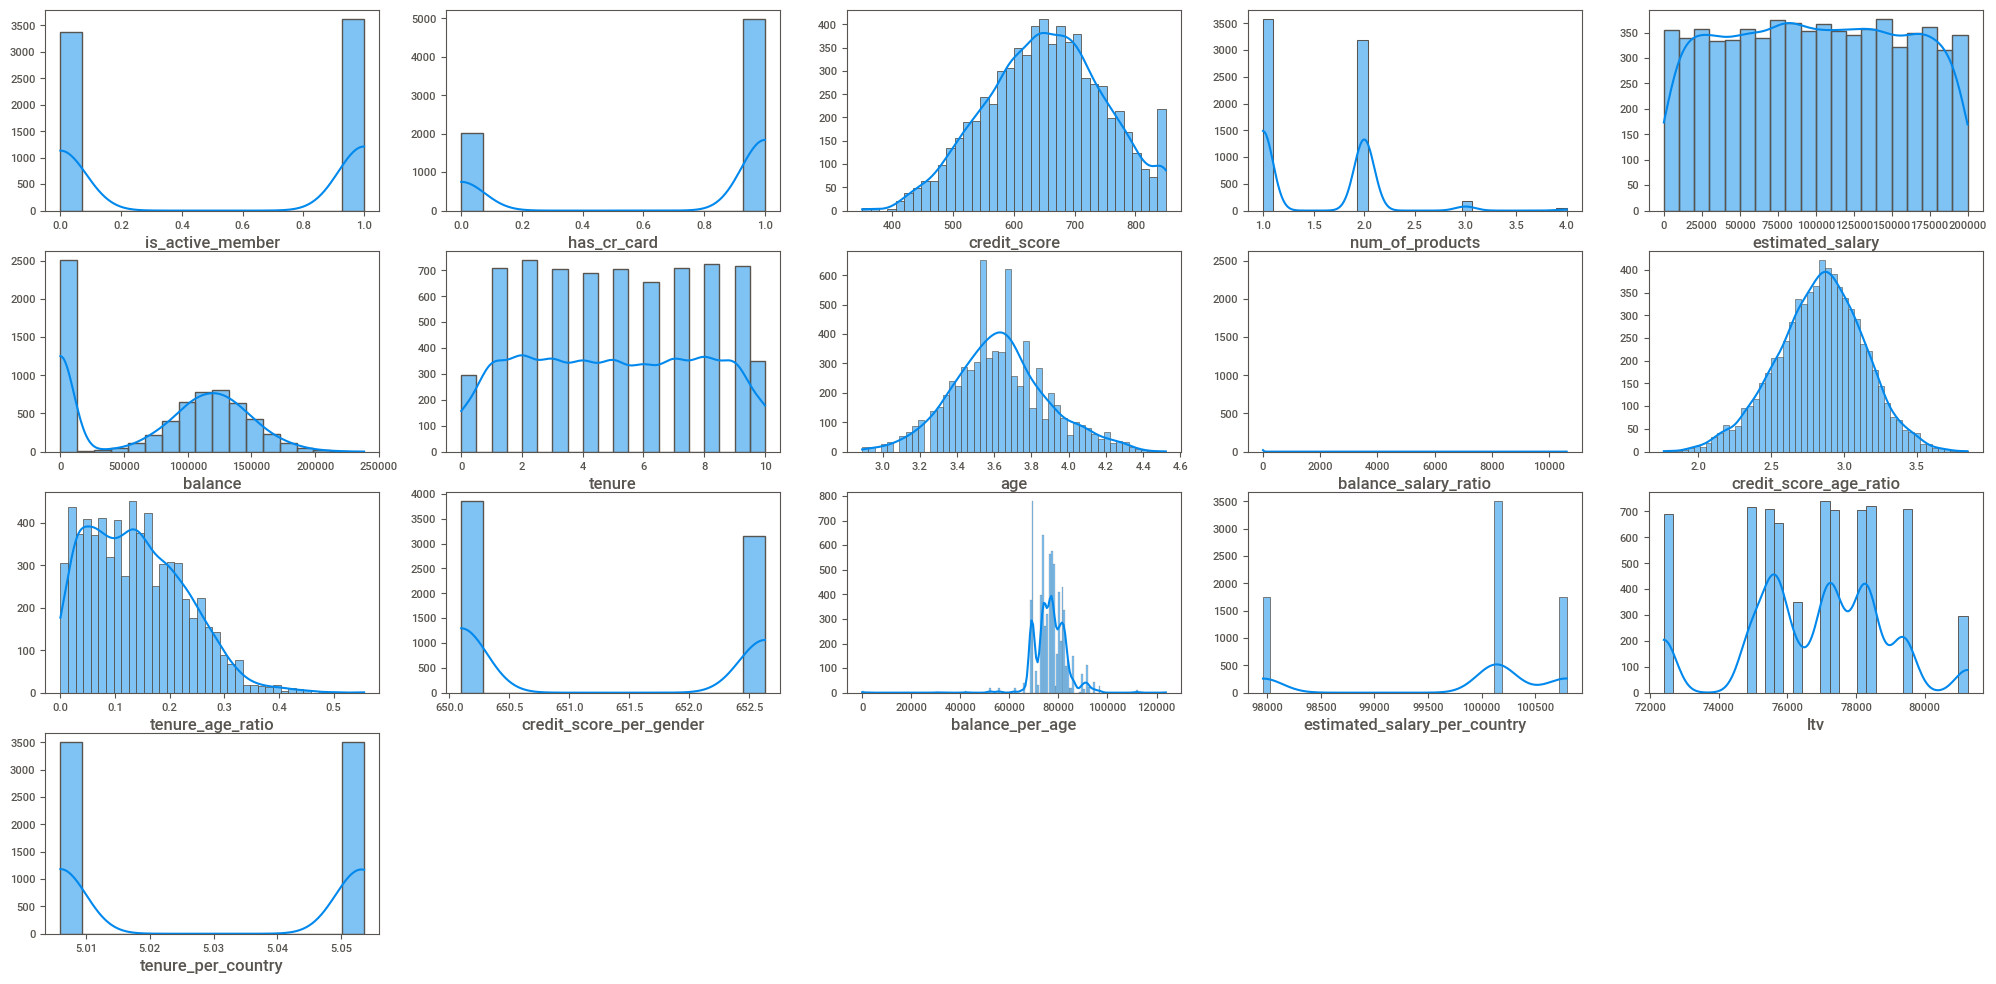

In [128]:
multiple_histplots(X_train.select_dtypes(include = ['int64', 'float64']), 4, 5);

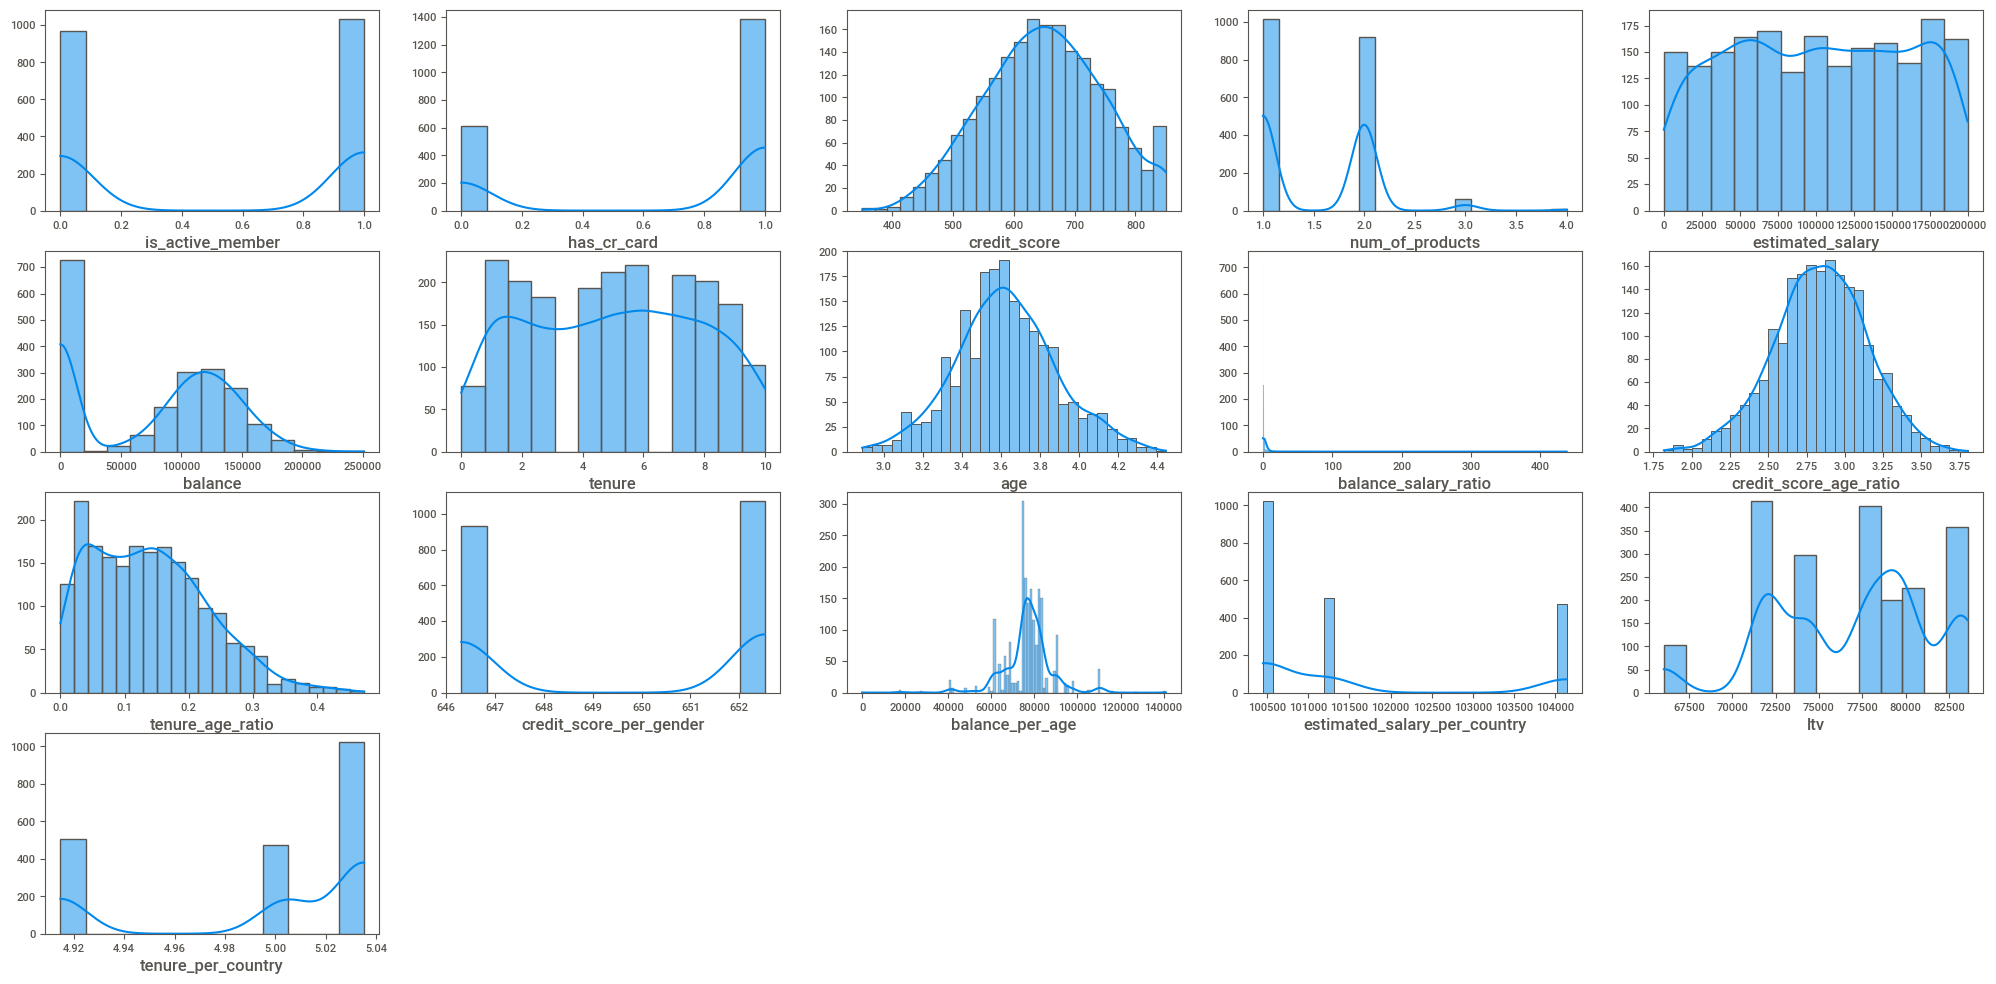

In [129]:
multiple_histplots(X_test.select_dtypes(include = ['int64', 'float64']), 4, 5);

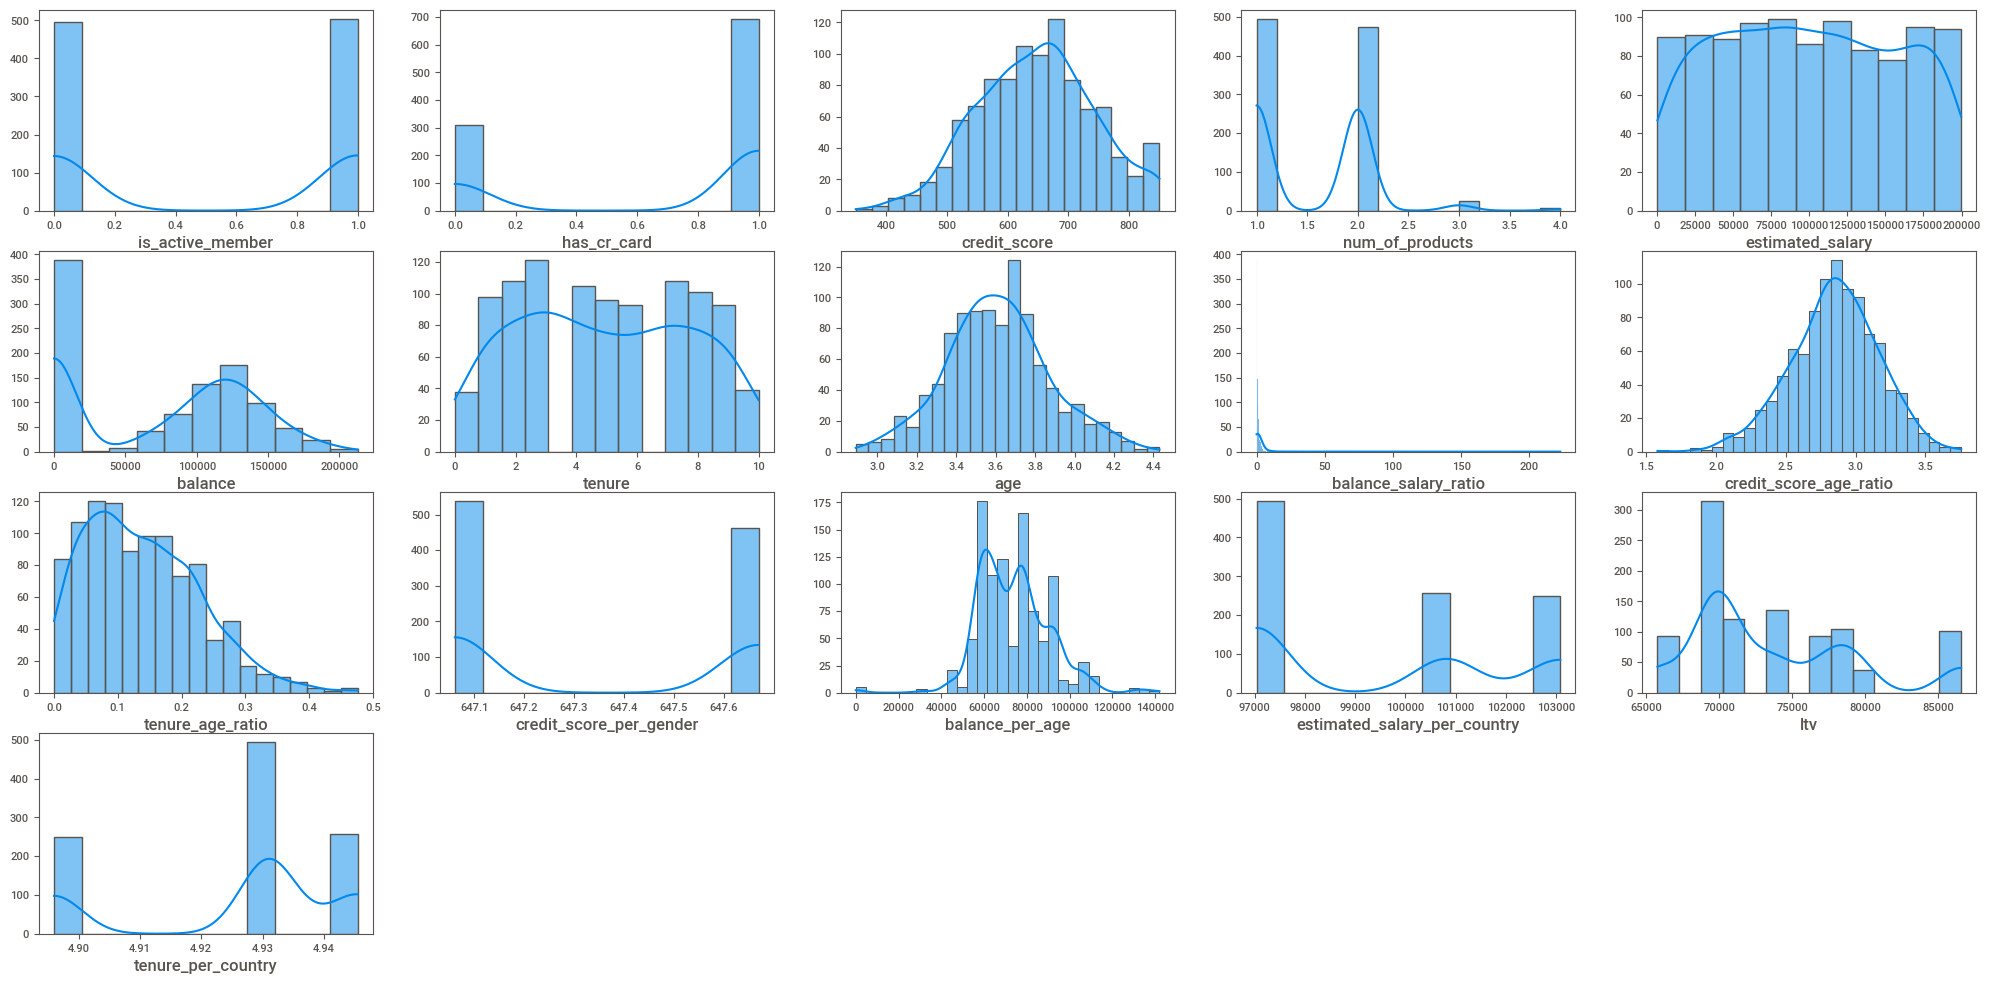

In [130]:
multiple_histplots(X_val.select_dtypes(include = ['int64', 'float64']), 4, 5);

In [131]:
# encoding
cols_ohe = ['geography', 'gender', 'balance_indicator']
cols_le = ['life_stage', 'cs_category', 'tenure_group']

# re-scaling
min_max_scaler = ['estimated_salary', 'balance', 'tenure', 'balance_salary_ratio', 'tenure_age_ratio',
                  'estimated_salary_per_country', 'ltv', 'tenure_per_country', 'credit_score_per_gender']

robust_scaler = ['credit_score', 'num_of_products', 'balance_per_age']

standard_scaler = ['age', 'credit_score_age_ratio']

rs = RobustScaler()
mms = MinMaxScaler()
ss = StandardScaler()
ohe = OneHotEncoder()


X_train, X_test, X_val = [pipeline_churn(dataframe, min_max_scaler, mms, robust_scaler, rs, standard_scaler, ss, cols_ohe, ohe, cols_le) for dataframe in [X_train, X_test, X_val]]

X_train.head()

,estimated_salary,balance,tenure,balance_salary_ratio,tenure_age_ratio,estimated_salary_per_country,ltv,tenure_per_country,credit_score_per_gender,credit_score,num_of_products,balance_per_age,age,credit_score_age_ratio,geography_france,geography_germany,geography_spain,gender_female,gender_male,balance_indicator_high,balance_indicator_low,_is_active_member,_has_cr_card,_life_stage,_cs_category,_tenure_group
0,0.583,0.577,0.100,0.000,0.033,1.000,0.788,1.000,1.000,-0.769,1.000,0.614,1.461,-1.786,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,3.000,2.000,2.000
1,0.667,0.373,0.900,0.000,0.426,1.000,0.289,1.000,0.000,-1.127,1.000,-0.378,0.027,-0.859,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,2.000,2.000,1.000
2,0.778,0.560,1.000,0.000,0.600,1.000,0.442,1.000,1.000,0.433,1.000,-0.335,-0.889,1.090,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000
3,0.650,0.527,0.700,0.000,0.406,1.000,0.363,1.000,0.000,-0.030,0.000,0.059,-0.762,0.676,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,2.000,1.000
4,0.421,0.719,1.000,0.000,0.667,1.000,0.442,1.000,1.000,-0.403,0.000,-0.475,-1.297,0.869,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,1.000,2.000,1.000


In [132]:
for dataframe in [X_train, X_test, X_val]:
    dataframe.rename(columns = {'_is_active_member': 'is_active_member', '_has_cr_card': 'has_cr_card', '_life_stage': 'life_stage', '_cs_category': 'cs_category', '_tenure_group': 'tenure_group'}, inplace = True)

### 4.2 Feature Selection

#### 4.2.1 Feature Importance with ExtraTrees

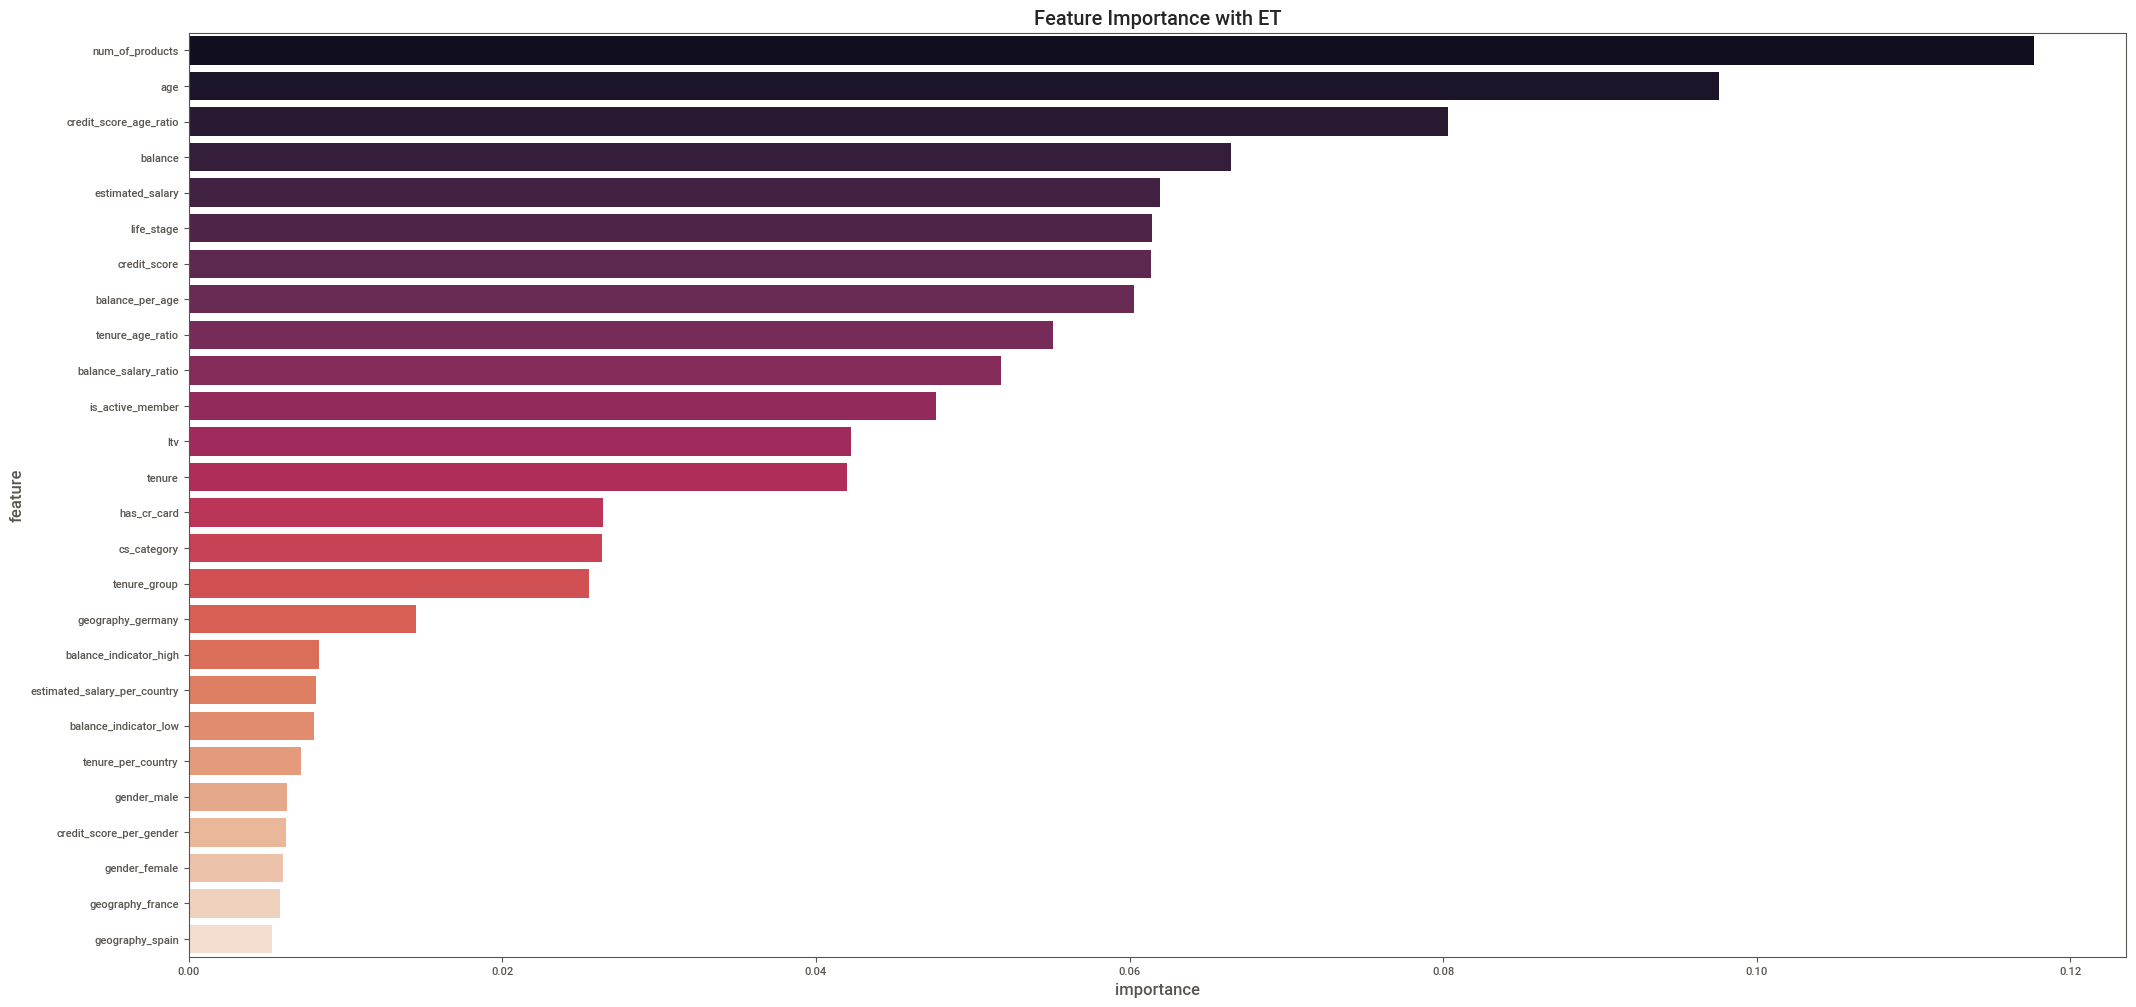

In [133]:
et_importance = ExtraTreesClassifier(n_estimators = 200, n_jobs = 14, random_state = seed)
et_importance.fit(X_train, y_train)

# Feature Importance DF
feature_selection = pd.DataFrame({'feature': X_train.columns, 'importance': et_importance.feature_importances_})\
                                    .sort_values('importance', ascending = False).reset_index(drop = True)

# Plot feature_selection
ax = sns.barplot(x = 'importance', y = 'feature', data = feature_selection, palette = 'rocket')
ax.set_title('Feature Importance with ET');


#saving figure
plt.savefig(homepath + 'reports/figures/FIET.png')


#### 4.2.2 Feature Importance with RandomForest

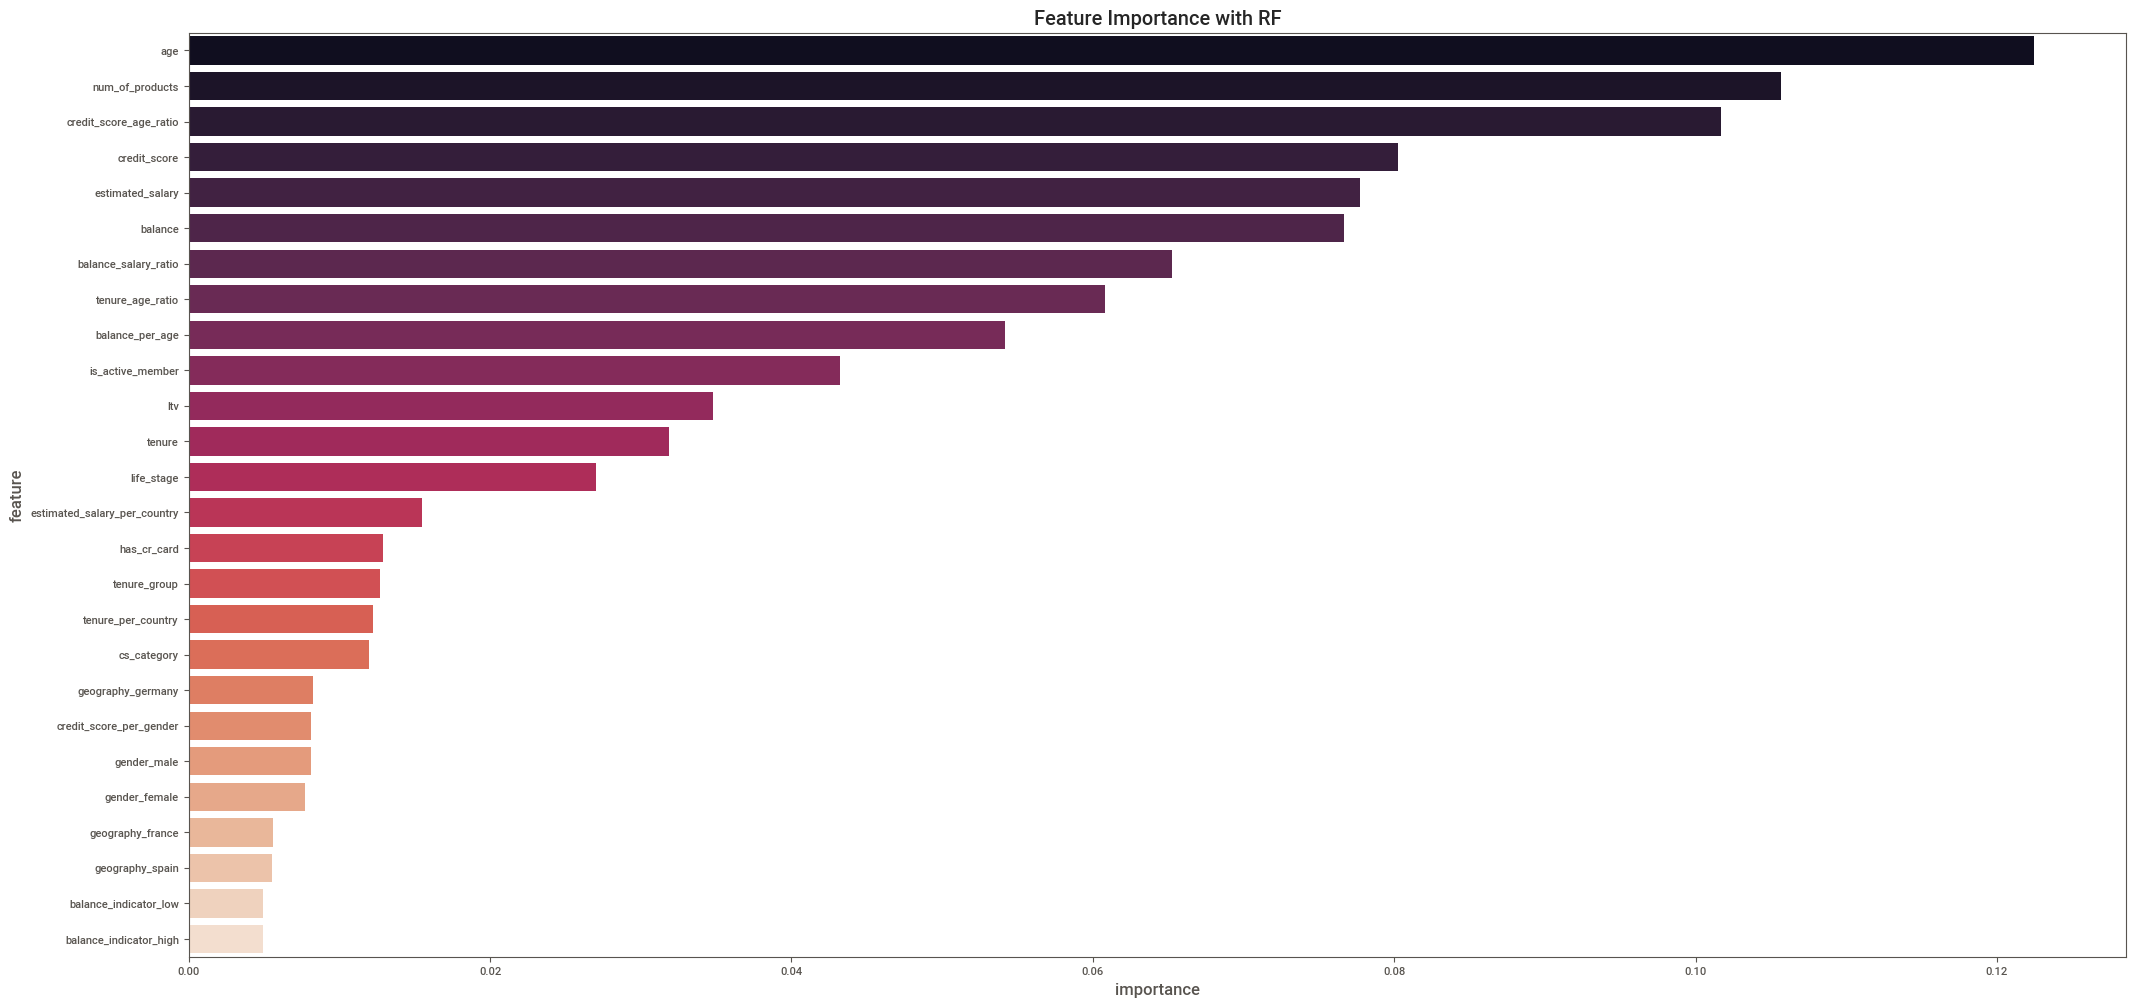

In [134]:
rf_importance = RandomForestClassifier(n_estimators = 200, n_jobs = 14, random_state = seed)
rf_importance.fit(X_train, y_train)

# Feature Importance DF
feature_selection = pd.DataFrame({'feature': X_train.columns, 'importance': rf_importance.feature_importances_})\
                                    .sort_values('importance', ascending = False).reset_index(drop = True)

# Plot feature_selection
ax = sns.barplot(x = 'importance', y = 'feature', data = feature_selection, palette = 'rocket')
ax.set_title('Feature Importance with RF');

#saving figure
plt.savefig(homepath + 'reports/figures/FIRF.png')


#### 4.2.3 Random Forest Selector

In [137]:
# feature selector
rf_selector = RandomForestClassifier(n_jobs = 14)
rfe = RFE(rf_selector, n_features_to_select = 12, step = 1)
rfe = rfe.fit(X_train, y_train)

# get ranking
rfe.support_

# selected columns
rfe_selected = X_train.loc[:, rfe.support_]
rfe_columns = rfe_selected.columns
rfe_columns

Index(['estimated_salary', 'balance', 'balance_salary_ratio',
       'tenure_age_ratio', 'estimated_salary_per_country', 'ltv',
       'credit_score', 'num_of_products', 'balance_per_age', 'age',
       'credit_score_age_ratio', 'is_active_member'],
      dtype='object')


#### 4.2.4 Ranking Features

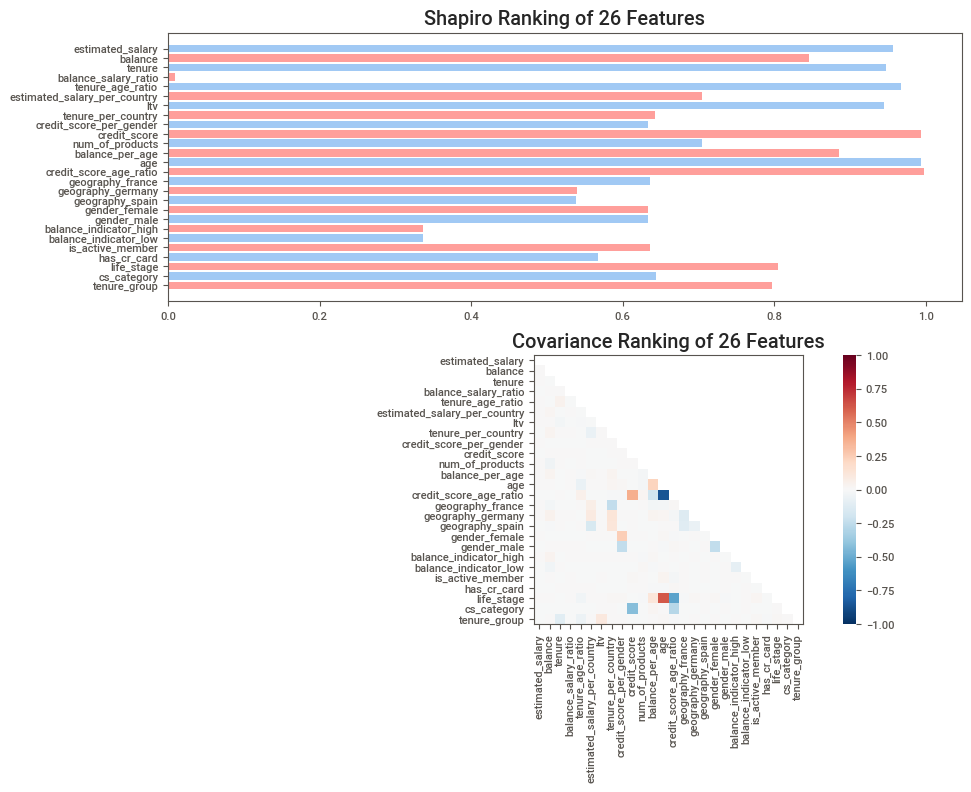

In [136]:
plt.subplot(2, 1, 1)
visualizer_1d = Rank1D(algorithm = 'shapiro', size = (1024, 768), color = ['#a1c9f4', '#ff9f9b'])
visualizer_1d.fit(X_train, y_train)           
visualizer_1d.transform(X_train)        
visualizer_1d.finalize();

plt.subplot(2, 1, 2)
visualizer_2d = Rank2D(algorithm='covariance', size = (1024, 768))
visualizer_2d.fit(X_train, y_train)
visualizer_2d.transform(X_train)
visualizer_2d.finalize();


#### 4.2.5 Feature Selection


These are the most relevant features of the FI-ET, FI-RF, FI-RFE and Rank Features:

| Features                       | FI ExtraTrees | FI RF | FI-RFE | Rank Features |
| ------------------------------ | ------------- | ----- | ------ | ------------- |
| `estimated_salary`             | [x]           | [x]   | [x]    | [x]           |
| `balance`                      | [x]           | [x]   | [x]    | [x]           |
| `tenure`                       | [x]           | [x]   |        | [x]           |
| `estimated_salary_per_country` |               |       | [x]    |               |
| `ltv`                          |               | [x]   | [x]    | [x]           |
| `tenure_per_country`           |               |       |        | [x]           |
| `credit_score_per_gender`      |               |       |        |               |
| `credit_score`                 | [x]           | [x]   | [x]    | [x]           |
| `num_of_products`              | [x]           | [x]   | [x]    | [x]           |
| `age`                          | [x]           | [x]   | [x]    | [x]           |
| `balance_per_age`              | [x]           | [x]   | [x]    | [x]           |
| `geography_france`             |               |       |        |               |
| `geography_germany`            |               |       |        |               |
| `geography_spain`              |               |       |        |               |
| `gender_female`                |               |       |        |               |
| `gender_male`                  |               |       |        |               |
| `is_active_member`             | [x]           | [x]   | [x]    |               |
| `has_cr_card`                  |               |       |        |               |
| `balance_salary_ratio`         | [x]           | [x]   | [x]    |               |
| `tenure_age_ratio`             | [x]           | [x]   | [x]    |               |
| `credit_score_age_ratio`       | [x]           | [x]   | [x]    |               |
| `life_stage`                   | [x]           |       |        |               |
| `cs_category`                  |               |       |        |               |
| `tenure_group`                 |               |       |        |               |
| `balance_indicator_low`        |               |       |        |               |
| `balance_indicator_high`       |               |       |        |               |


We can consider that if the feature appears in all models it is a important feature for the modelling step, in this scenario we have: 
- `estimated_salary`
- `balance`
- `tenure`
- `ltv`
- `credit_score` 
- `num_of_products`
- `age`
- `balance_per_age` 

In EDA, the features with the highest correlation with target `exited` are:
- `age`
- `balance_per_age`
- `geography`
- `is_active_member`
- `estimated_salary_per_country`
- `gender`
- `geography`
- 
According the EDA, the churn ratio in Germany is higher than Spain and France, because of that, I consider these features relevant.

Women has a higher tendency to be in churn than men, this was seen in EDA. This tendency is interesting and could be relevant in the machine learning modelling.

Studying a little about the business model, `estimated_salary`, `tenure`, `balance`, `gender` and `geography` are the most relevant variables in a lot of cases.

With these three sources of information, I believe that the most relevant features for modeling models are:
- `estimated_salary`
- `balance`
- `tenure`
- `ltv`
- `credit_score`
- `num_of_products`
- `age`
- `balance_per_age` 
- `is_active_member`
- `gender_female`
- `gender_male`
- `geography_france`
- `geography_spain`
- `geography_spain`

In [ ]:
X_test.columns

In [ ]:

cols_drop = ['estimated_salary_per_country', 'tenure_per_country', 'credit_score_per_gender', '_has_cr_card']

X_train, X_test, X_val = [dataframe.drop(columns = cols_drop) for dataframe in [X_train, X_test, X_val]]


#### 4.2.6 Save State

In [ ]:
X_train.to_pickle(homepath + 'data/processed/X_train.pkl')
X_test.to_pickle(homepath + 'data/processed/X_test.pkl')
X_val.to_pickle(homepath + 'data/processed/X_val.pkl')

### 4.3 Model Selection

#### 4.3.1 Load Dataset

In [ ]:
X_train = pd.read_pickle(homepath + 'data/processed/X_train.pkl')
X_val = pd.read_pickle(homepath + 'data/processed/X_val.pkl')

y_train = pd.read_pickle(homepath + 'data/processed/y_train.pkl')
y_val = pd.read_pickle(homepath + 'data/processed/y_val.pkl')

#### 4.3.2 Setting and Models

In [ ]:
class_weights = {0: 0.8, 1: 0.2}


classifiers_list = [
    KNeighborsClassifier(n_neighbors = 5),
    LogisticRegression(class_weight = class_weights, random_state = seed),
    DecisionTreeClassifier(class_weight = class_weights, random_state = seed),
    RandomForestClassifier(class_weight = class_weights, random_state = seed),
    AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1), random_state = seed),
    GradientBoostingClassifier(random_state = seed),
    ExtraTreesClassifier(class_weight = class_weights, random_state = seed),
    GaussianNB(),
    XGBClassifier(scale_pos_weight = 0.2, objective = 'binary:logistic', eval_metric = 'logloss', random_state = seed),
    LGBMClassifier(is_unbalance = True, objective = 'binary', metric = 'binary_logloss', random_state = seed),
    CatBoostClassifier(class_weights = class_weights, random_state = seed)
]

#### 4.3.3 Evaluation

Some information before start:

**Precision**: Precision is a metric used in classification tasks. It measures the proportion of true positive predictions (correctly predicted positive instances) out of all instances predicted as positive. It's a measure of the model's accuracy when it predicts positive results.

**Recall (Sensitivity)**: Recall, also known as sensitivity or true positive rate, measures the proportion of true positive predictions out of all actual positive instances. It's a measure of how well the model captures all positive instances.

**F1-Score**: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. It's particularly useful when you want to consider both false positives and false negatives and find a single metric that represents their trade-off.

**ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)**: ROC-AUC is a metric used for evaluating the performance of binary classification models. It quantifies the ability of the model to distinguish between positive and negative classes by measuring the area under the receiver operating characteristic curve. A higher ROC-AUC value indicates a better model's ability to discriminate between the classes.

In churn cases, it's often better to evaluate the model using the F1-score.


#### 4.3.4 Model Metrics

In [ ]:
metrics_result = metrics_models(classifiers_list, X_train, y_train, X_val, y_val)

In [ ]:
metrics_result

#### 4.3.5 Cross-Validation

In [ ]:
cv_result = metrics_cv(classifiers_list, X_train, y_train)

In [ ]:
cv_result.style.apply(highlight_max)

#### 4.3.6 Lift Curve and Cumulative Gain


**Cumulative gain**: X% of the customer base, ordered by probability of purchase contains Y% of everyone interested in the new product.

**Lift Curve**: How many times the ML model is batter than a baseline model for each % of base?

In [ ]:
ranking_plots(classifiers_list, X_train, y_train, X_val, y_val)

#### 4.3.7 Hyperparameter Fine Tuning

##### 4.3.7.1 Bayesian Search

Bayesian Optimization provides a principled technique based on Bayes Theorem to direct a search of a global optimization problem that is efficient and effective.

##### 4.3.7.2 LGBM Classifier

In [ ]:
#study_lgbm = optuna.create_study(direction = 'minimize', study_name = 'LGBM')
#func = lambda trial: objective_lgbm(trial, X_train, y_train)
#study_lgbm.optimize(func, n_trials = 50)

In [ ]:
#optuna.visualization.plot_optimization_history(study_lgbm)

In [ ]:
#optuna.visualization.plot_param_importances(study_lgbm)

In [ ]:
#print(f"\tBest value (log loss): {study_lgbm.best_value}")
#print(f"\tBest params:")
#
#for key, value in study_lgbm.best_params.items():
#    print(f"\t\t{key}: {value}")


##### 4.3.7.3 GradientBoosting Classifier

In [ ]:
#study_gb = optuna.create_study(direction = 'minimize', study_name = 'GradientBoosting')
#func = lambda trial: objective_gb(trial, X_train, y_train)
#study_gb.optimize(func, n_trials = 70, n_jobs = 15)

In [ ]:
#print(f"\tBest value (log loss): {study_gb.best_value}")
#print(f"\tBest params:")

#for key, value in study_gb.best_params.items():
#    print(f"\t\t{key}: {value}")

##### 4.3.7.4 XGBoost Classifier

In [ ]:
#study_xgb = optuna.create_study(direction = 'minimize', study_name = 'XGBoost Classifier')
#func = lambda trial: objective_xgb(trial, X_train, y_train)
#study_xgb.optimize(func, n_trials = 70, n_jobs = 15)

In [ ]:
#print(f"\tBest value (log loss): {study_xgb.best_value}")
#print(f"\tBest params:")

#for key, value in study_gb.best_params.items():
#    print(f"\t\t{key}: {value}")

#### 4.3.7.5 CatBoost Classifier

In [ ]:
#study_cb = optuna.create_study(direction = 'minimize', study_name = 'CatBoost Classifier')
#func = lambda trial: objective_cb(trial, X_train, y_train)
#study_cb.optimize(func, n_trials = 70, n_jobs = 15)

In [ ]:
#print(f"\tBest value (log loss): {study_cb.best_value}")
#print(f"\tBest params:")

#for key, value in study_cb.best_params.items():
#    print(f"\t\t{key}: {value}")

#### 4.3.7.6 Select Model

In [ ]:
# threshold
# tunned with optuna
models = [  GradientBoostingClassifier(n_estimators = 2000, learning_rate = 0.18123323702901284, max_depth = 10, min_samples_split = 4, min_samples_leaf = 2, random_state = 42),
            XGBClassifier(n_estimators = 2000, learning_rate = 0.18123323702901284, max_depth = 10, min_samples_split = 4, min_samples_leaf = 2, n_jobs = 14, random_state = 42, scale_pos_weight = 4, objective = 'binary:logistic', eval_metric = 'logloss'),
            CatBoostClassifier(n_estimators = 1500, learning_rate = 0.27926103613489817, max_depth = 11)
         ]

# Showing results in one dataframe
metrics_optuna = metrics_models(models, X_train, y_train, X_val, y_val)
cv_optuna = metrics_cv(models, X_train, y_train)
result = pd.merge(metrics_optuna, cv_optuna, on = 'Model_Name', how = 'left')
result.style.apply(highlight_max)

##### 4.3.7.6.1 ROCAUC and Confusion Matrix

In [ ]:
rocauc(models, X_train, y_train, X_val, y_val)

In [ ]:
confusion_matrix(models, X_train, y_train, X_test, y_test)

##### 4.3.7.6.1 Cumulative Gain and Lift Curve

In [ ]:
yhat_list = []
for model in models:
    model.fit(X_train, y_train)
    yhat_full = model.predict_proba(X_val)
    yhat = yhat_full[:,1]
    yhat_list.append(yhat)

In [ ]:
fig, ax = plt.subplots(figsize = (25, 15))

plt.subplot(1, 2, 1)
plot_cumulative_gain(y_val, yhat_list[0])
plot_cumulative_gain(y_val, yhat_list[1])
plot_cumulative_gain(y_val, yhat_list[2])
plt.yticks(np.arange(0, 100, step = 10));
plt.legend(['GrandientBoosting', 'Wizard', 'Baseline' , 'XGBoost', 'Wizard', 'Baseline', 'CatBoost', 'Wizard', 'Baseline'])

plt.subplot(1, 2, 2)
plot_lift(y_val, yhat_list[0])
plot_lift(y_val, yhat_list[1])
plot_lift(y_val, yhat_list[2])
plt.legend(['GradientBoosting', 'Baseline', 'XGBoost', 'Baseline', 'CatBoost', 'Baseline'])

#saving figure
plt.savefig(homepath + 'reports/figures/model_results')

#### 4.3.7.7 Selected Model Performance

In [ ]:
final_model_performance = CatBoostClassifier(n_estimators = 1500, learning_rate = 0.27926103613489817, max_depth = 11)


In [ ]:
X_data = pd.concat([X_train, X_val], axis = 0)
y_data = pd.concat([y_train, y_val], axis = 0)

In [ ]:
final_model_performance.fit(X_data, y_data)

yhat_final = final_model_performance.predict_proba(X_test)

In [ ]:
pickle.dump(final_model_performance, open(homepath + 'models/churn_prediction.pkl', 'wb'))

## 5. Bussiness Translation

In [ ]:
model = pickle.load(open(homepath + 'models/churn_prediction.pkl', 'rb'))

### 5.1 What is Top Bank's current Churn rate?

In [ ]:
churn_rate = df1_cat[df1_cat['exited'] == 'yes']['exited'].count()/(len(df1_cat))
round(churn_rate*100, 2)

The current churn rate is 20.37%

### 5.2 What is the performance of the model in classifying customers as churns?


In [ ]:
metrics_result = metrics_models([model], X_data, y_data, X_test, y_test)

In [ ]:
metrics_result

#### 5.4 What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

##### 5.4.1 Creating DataFrame

In [ ]:
#df_verify = pd.concat([X_train, X_test, X_val], axis = 0)
#y_data = pd.concat([y_train, y_test, y_val], axis = 0)

salary_mean = round(df1['estimated_salary'].mean(), 2)

# loading model and predictions
y_predict_proba = pd.DataFrame(model.predict_proba(X_test))
y_predict = pd.DataFrame(model.predict(X_test))

# estimated salary with MinMaxScaler
estimated_salary = X_test[['estimated_salary']]

# returning the transformation
estimated_salary['estimated_salary'] = mms.inverse_transform(estimated_salary[['estimated_salary']].values)

# creating df
df = pd.concat((y_test, estimated_salary), axis = 1).reset_index(drop = True)
df = pd.concat((df, y_predict_proba), axis = 1).reset_index(drop = True)
df = df.rename(columns = {1: 'prediction_proba'})
df.drop(0, axis = 1, inplace=True)
df = pd.concat((df, y_predict), axis = 1).reset_index(drop = True)
df = df.rename(columns = {0: 'prediction'})

In [ ]:
df5.head()